# Flatiron Health aNSCLC: Relaxed trials with GBM crude + dose correction

***OBJECTIVE:*** **Reproduce landmark clinical trials in aNSCLC while ensuring patient receiving chemotherapy are getting appropriate first dose. Inclusion criteria for these trials will be pragmatically relaxed to allow for entry of our real-world patients, many of which would not meet criteria for inclusion in randomized controlled trials. Patients included in our trials will next be risk stratified using the gradient boosted model with crude imputation into 1 of 3 risk groups: high (top tertile), medium (middle tertile), and low (bottom tertile). Inverse-probability treatment weighted survival analysis will then be performed across these risk groups to get real-world estimates of survival while adjusting for measured confounders.** 

***OUTLINE:***
1. **Preprocessing**
2. **In silico trials:**
* KEYNOTE-042 
* KEYNOTE-024
* KEYNOTE-189 
* CHECKMATE-078

## Part 1: Preprocessing

### 1.1 Import packages and create necessary functions

In [1]:
import numpy as np
import pandas as pd

from scipy import stats

from sksurv.nonparametric import kaplan_meier_estimator
from survive import KaplanMeier, SurvivalData

from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.utils import median_survival_times

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.linear_model import LogisticRegression

from matplotlib.lines import Line2D   

In [2]:
# Function that returns number of rows and count of unique PatientIDs for a dataframe. 
def row_ID(dataframe):
    row = dataframe.shape[0]
    ID = dataframe['PatientID'].nunique()
    return row, ID

## Part 2: In-silico trials 

### KEYNOTE-042: First-line pembrolizumab vs. platinum-based chemotherapy in those with PDL1 >=1%

**INCLUSION CRITERIA**
* Untreated locally advanced or metastatic NSCLC
* Received first line pemobrolizumab or platinum-based chemotherapy
* Received appropriate dose of platinum-based chemotherapy
* PDL1 >= 1% and status known within (-inf, +30] days of first-line treatment
* EGFR and ALK negative

#### Pembrolizumab

In [3]:
df_full = pd.read_csv('df_risk_crude.csv', index_col = 'PatientID', dtype = {'death_status': bool})
df_full.index.nunique()

68483

In [4]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [5]:
key042_pembro = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1')
    .query('IsMaintenanceTherapy == False')
    .query('LineName == "Pembrolizumab"')
    [['PatientID', 'StartDate']]
)

In [6]:
key042_pembro.loc[:, 'pembro'] = 1

In [7]:
row_ID(key042_pembro)

(3648, 3648)

In [8]:
# Dataframe of all therapies received for those receiving first line pembrolizumab only. 
line_therapy_pembro_042 = (
    line_therapy[line_therapy['PatientID'].isin(key042_pembro.PatientID)])

In [9]:
targeted = [
    'Afatinib',
    'Alectinib',
    'Brigatinib',
    'Cabozantinib',
    'Capmatinib',
    'Ceritinib',
    'Crizotinib',
    'Dabrafenib',
    'Dacomitinib',
    'Entrectinib',
    'Erlotinib',
    'Gefitinib',
    'Lorlatinib',
    'Osimertinib',
    'Pralsetinib',
    'Selpercatinib',
    'Sotorasib',
    'Tepotinib',
    'Trametinib',
    'Vandetanib']

In [10]:
# Patients receiving pembrolizumab therapy who later recieve targeted therapy. 
pembro_042_xcross = (
    line_therapy_pembro_042[line_therapy_pembro_042['LineName'].str.contains('|'.join(targeted))].PatientID)

In [11]:
# Select patients who don't receive targeted therapy in future lines.
key042_pembro = key042_pembro[~key042_pembro['PatientID'].isin(pembro_042_xcross)]

In [12]:
row_ID(key042_pembro)

(3582, 3582)

In [13]:
row_ID(key042_pembro)

(3582, 3582)

#### Platinum-based chemotherapy 

In [14]:
line_therapy_fl = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1')
    .query('IsMaintenanceTherapy == False')
)

In [15]:
plat_chemo = [
    'Carboplatin',
    'Cisplatin']

immuno = [
    'Atezolizumab',
    'Cemiplimab',
    'Durvalumab',
    'Ipilimumab',
    'Nivolumab',
    'Pembrolizumab'
]

In [16]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('|'.join(plat_chemo)) & 
                ~line_therapy_fl['LineName'].str.contains('|'.join(immuno)) &
                ~line_therapy_fl['LineName'].str.contains('|'.join(targeted)) &
                ~line_therapy_fl['LineName'].str.contains('Clinical Study Drug')].LineName.value_counts().head(10)

Carboplatin,Paclitaxel                  8524
Carboplatin,Pemetrexed                  5417
Bevacizumab,Carboplatin,Pemetrexed      2825
Carboplatin,Paclitaxel Protein-Bound    1826
Bevacizumab,Carboplatin,Paclitaxel      1591
Carboplatin,Gemcitabine                 1224
Cisplatin,Etoposide                      793
Carboplatin,Docetaxel                    780
Cisplatin,Pemetrexed                     684
Carboplatin,Etoposide                    363
Name: LineName, dtype: int64

In [17]:
key042_carb = (
    line_therapy_fl[line_therapy_fl['LineName'].str.contains('Carboplatin') & 
                    ~line_therapy_fl['LineName'].str.contains('|'.join(immuno)) &
                    ~line_therapy_fl['LineName'].str.contains('|'.join(targeted)) &
                    ~line_therapy_fl['LineName'].str.contains('Clinical Study Drug')]
    [['PatientID', 'StartDate']]
)

In [18]:
key042_carb.loc[:, 'carb'] = 1

In [19]:
key042_cis = (
    line_therapy_fl[line_therapy_fl['LineName'].str.contains('Cisplatin') & 
                    ~line_therapy_fl['LineName'].str.contains('|'.join(immuno)) &
                    ~line_therapy_fl['LineName'].str.contains('|'.join(targeted)) &
                    ~line_therapy_fl['LineName'].str.contains('Clinical Study Drug')]
    [['PatientID', 'StartDate']]
)

In [20]:
key042_cis.loc[:, 'carb'] = 0

In [21]:
key042_plat = pd.concat([key042_carb, key042_cis])

In [22]:
key042_plat.loc[:, 'pembro'] = 0

In [23]:
row_ID(key042_plat)

(25861, 25861)

In [24]:
# Dataframe of all therapies received for those receiving first line platinum regimen   
line_therapy_plat_042 = (
    line_therapy[line_therapy['PatientID'].isin(key042_plat.PatientID)])

In [25]:
# Patients receiving platinum therapy who later recieve targeted therapy. 
plat_042_xcross = (
    line_therapy_plat_042[line_therapy_plat_042['LineName'].str.contains('|'.join(targeted))].PatientID)

In [26]:
# Select patients who don't receive targeted therapy in future lines 
key042_plat = key042_plat[~key042_plat['PatientID'].isin(plat_042_xcross)]

In [27]:
row_ID(key042_plat)

(23800, 23800)

#### Platinum-based chemotherapy dosing

#### Carboplatin

In [28]:
med_order = pd.read_csv('MedicationOrder.csv', low_memory = False)

In [29]:
med_order['ExpectedStartDate'] = np.where(med_order['ExpectedStartDate'].isna(), 
                                          med_order['OrderedDate'], 
                                          med_order['ExpectedStartDate'])

In [30]:
med_order.loc[:, 'ExpectedStartDate'] = pd.to_datetime(med_order['ExpectedStartDate'])

In [31]:
key042_plat.loc[:, 'StartDate'] = pd.to_datetime(key042_plat['StartDate'])

In [32]:
med_order_carb = (
    med_order[med_order['PatientID'].isin(key042_plat.query('carb == 1').PatientID)]
    .query('CommonDrugName == "carboplatin"')
)

In [33]:
med_order_carb.shape

(147262, 18)

In [34]:
med_order_carb = pd.merge(med_order_carb, 
                          key042_plat.query('carb == 1')[['PatientID', 'StartDate']], 
                          on = 'PatientID', 
                          how = 'left')

In [35]:
med_order_carb.shape

(147262, 19)

In [36]:
med_order_carb.loc[:, 'date_diff'] = (med_order_carb['ExpectedStartDate'] - med_order_carb['StartDate']).dt.days.abs()

In [37]:
med_order_carb = med_order_carb.query('date_diff <= 14')

In [38]:
carb_index = med_order_carb.groupby('PatientID')['date_diff'].idxmin()

In [39]:
carb_dose = med_order_carb.loc[carb_index].query('RelativeOrderedUnits == "AUC"')[['PatientID', 'RelativeOrderedAmount']]

In [40]:
carb_dose = carb_dose.rename(columns = {'RelativeOrderedAmount': 'carb_dose_auc'})

In [41]:
carb_IDs = carb_dose.query('carb_dose_auc >= 5').PatientID

#### Cisplatin

In [42]:
med_order_cis = (
    med_order[med_order['PatientID'].isin(key042_plat.query('carb == 0').PatientID)]
    .query('CommonDrugName == "cisplatin"')
)

In [43]:
med_order_cis.shape

(10521, 18)

In [44]:
med_order_cis = pd.merge(med_order_cis,
                         key042_plat.query('carb == 0')[['PatientID', 'StartDate']], 
                         on = 'PatientID', 
                         how = 'left')

In [45]:
med_order_cis.shape

(10521, 19)

In [46]:
med_order_cis.loc[:, 'date_diff'] = (med_order_cis['ExpectedStartDate'] - med_order_cis['StartDate']).dt.days.abs()

In [47]:
med_order_cis = med_order_cis.query('date_diff <= 14')

In [48]:
cis_index = med_order_cis.groupby('PatientID')['date_diff'].idxmin()

In [49]:
cis_dose = med_order_cis.loc[cis_index].query('RelativeOrderedUnits == "mg/m2"')[['PatientID', 'RelativeOrderedAmount']]

In [50]:
cis_dose = cis_dose.rename(columns = {'RelativeOrderedAmount': 'cis_dose_mgm2'})

In [51]:
cis_IDs = cis_dose.query('cis_dose_mgm2 >= 75').PatientID

#### Combine chemotherapy and pembrolizumab dataframes 

In [52]:
key042_plat = key042_plat[key042_plat['PatientID'].isin(pd.concat([carb_IDs, cis_IDs]))]

In [53]:
key042_plat = key042_plat.drop(columns = ['carb'])

In [54]:
key_042 = pd.concat([key042_pembro, key042_plat])

In [55]:
row_ID(key_042)

(15321, 15321)

In [56]:
key_042 = pd.merge(key_042, df_full, on = 'PatientID', how = 'inner')

In [57]:
row_ID(key_042)

(15321, 15321)

In [58]:
key_042['StartDate'] = pd.to_datetime(key_042['StartDate'])

#### PDL1 >=1%

In [59]:
biomarkers = pd.read_csv('Enhanced_AdvNSCLCBiomarkers.csv')

In [60]:
biomarkers = biomarkers[biomarkers['PatientID'].isin(key_042['PatientID'])]

In [61]:
biomarkers = pd.merge(biomarkers, key_042[['PatientID', 'StartDate']], on = 'PatientID', how = 'left')

In [62]:
row_ID(biomarkers)

(58666, 12087)

In [63]:
biomarkers['ResultDate'] = pd.to_datetime(biomarkers['ResultDate'])

In [64]:
biomarkers['SpecimenReceivedDate'] = pd.to_datetime(biomarkers['SpecimenReceivedDate'])

In [65]:
biomarkers.loc[:, 'result_date'] = (
    np.where(biomarkers['ResultDate'].isna(), biomarkers['SpecimenReceivedDate'], biomarkers['ResultDate'])
)

In [66]:
biomarkers.loc[:, 'date_diff'] = (biomarkers['result_date'] - biomarkers['StartDate']).dt.days

In [67]:
pdl1_value = (
    biomarkers
    .query('BiomarkerName == "PDL1"')
    .query('date_diff <=30')
    .query('PercentStaining != "0%" and PercentStaining != "< 1%" and PercentStaining.notnull()', engine = 'python')
    .sort_values(by = ['PatientID', 'PercentStaining'], ascending = [True, False])
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    [['PatientID', 'PercentStaining']]
)

In [68]:
pdl1_ids = (
    biomarkers
    .query('BiomarkerName == "PDL1"')
    .query('date_diff <=30')
    .query('PercentStaining != "0%" and PercentStaining != "< 1%" and PercentStaining.notnull()', engine = 'python')
    .PatientID
    .unique()
)

In [69]:
key_042 = key_042[key_042.PatientID.isin(pdl1_ids)]

In [70]:
row_ID(key_042)

(4086, 4086)

#### Time from treatment to death or censor

In [71]:
mortality_tr = pd.read_csv('mortality_cleaned_tr.csv')

In [72]:
mortality_te = pd.read_csv('mortality_cleaned_te.csv')

In [73]:
mortality_tr = mortality_tr[['PatientID', 'death_date', 'last_activity']]

In [74]:
mortality_te = mortality_te[['PatientID', 'death_date', 'last_activity']]

In [75]:
mortality = pd.concat([mortality_tr, mortality_te], ignore_index = True)
print(len(mortality), mortality.PatientID.is_unique)

68483 True


In [76]:
mortality.loc[:, 'last_activity'] = pd.to_datetime(mortality['last_activity'])

In [77]:
mortality.loc[:, 'death_date'] = pd.to_datetime(mortality['death_date'])

In [78]:
key_042 = pd.merge(key_042, mortality, on = 'PatientID')

In [79]:
row_ID(key_042)

(4086, 4086)

In [80]:
conditions = [
    (key_042['death_status'] == 1),
    (key_042['death_status'] == 0)]

choices = [
    (key_042['death_date'] - key_042['StartDate']).dt.days,
    (key_042['last_activity'] - key_042['StartDate']).dt.days]

key_042.loc[:, 'timerisk_treatment'] = np.select(conditions, choices)

In [81]:
key_042 = key_042.query('timerisk_treatment >= 0')

#### Patient count

In [82]:
key_042 = (
    key_042
    .query('EGFR != "positive"')
    .query('ALK != "positive"')
)

In [83]:
low_cutoff_042 = key_042.risk_score.quantile(1/3)

In [84]:
high_cutoff_042 = key_042.risk_score.quantile(2/3)

In [85]:
print('Pembro total:',  key_042.query('pembro == 1').shape[0])
print('High risk:', key_042.query('pembro == 1').query('risk_score >= @high_cutoff_042').shape[0])
print('Med risk:', key_042.query('pembro == 1').query('risk_score < @high_cutoff_042 and risk_score > @low_cutoff_042').shape[0])
print('Low risk:', key_042.query('pembro == 1').query('risk_score <= @low_cutoff_042').shape[0])

Pembro total: 2914
High risk: 983
Med risk: 963
Low risk: 968


In [86]:
print('Platinum total:',  key_042.query('pembro == 0').shape[0])
print('High risk:', key_042.query('pembro == 0').query('risk_score >= @high_cutoff_042').shape[0])
print('Med risk:', key_042.query('pembro == 0').query('risk_score < @high_cutoff_042 and risk_score > @low_cutoff_042').shape[0])
print('Low risk:', key_042.query('pembro == 0').query('risk_score <= @low_cutoff_042').shape[0])

Platinum total: 1077
High risk: 348
Med risk: 367
Low risk: 362


#### Survival curves with covariate balancing

In [87]:
row_ID(key_042)

(3991, 3991)

In [88]:
key_042 = pd.merge(key_042, pdl1_value, on = 'PatientID', how = 'left')

In [89]:
row_ID(key_042)

(3991, 3991)

In [90]:
conditions = [
    (key_042['PercentStaining'] == "1%") | 
    (key_042['PercentStaining'] == "2% - 4%") |
    (key_042['PercentStaining'] == "5% - 9%") |
    (key_042['PercentStaining'] == "10% - 19%") |
    (key_042['PercentStaining'] == "20% - 29%") |
    (key_042['PercentStaining'] == "30% - 39%") |
    (key_042['PercentStaining'] == "40% - 49%") |
    (key_042['PercentStaining'].isna())
]

choices = ['lt50']

key_042['pdl1_det'] = np.select(conditions, choices, default = 'gte50')

In [91]:
key_042 = key_042.set_index('PatientID')

In [92]:
key_042_iptw = key_042.filter(items = ['death_status',
                                       'timerisk_treatment',
                                       'pembro',
                                       'age',
                                       'gender',
                                       'race',
                                       'PracticeType',
                                       'Histology',
                                       'adv_year',
                                       'delta_adv_diagnosis',
                                       'commercial',
                                       'medicare',
                                       'medicaid',
                                       'ecog_diagnosis',
                                       'pdl1_det',
                                       'risk_score'])

In [93]:
key_042_iptw['met_cat'] = pd.cut(key_042_iptw['adv_year'],
                                 bins = [2010, 2016, float('inf')],
                                 labels = ['11-16', '17-21'])

In [94]:
conditions = [
    ((key_042_iptw['ecog_diagnosis'] == "1.0") | (key_042_iptw['ecog_diagnosis'] == "0.0")),  
    ((key_042_iptw['ecog_diagnosis'] == "2.0") | (key_042_iptw['ecog_diagnosis'] == "3.0"))
]

choices = ['lt_2', 'gte_2']

key_042_iptw['ecog_2'] = np.select(conditions, choices, default = 'unknown')

In [95]:
key_042_iptw.dtypes

death_status               bool
timerisk_treatment      float64
pembro                    int64
age                       int64
gender                   object
race                     object
PracticeType             object
Histology                object
adv_year                  int64
delta_adv_diagnosis       int64
commercial              float64
medicare                float64
medicaid                float64
ecog_diagnosis           object
pdl1_det                 object
risk_score              float64
met_cat                category
ecog_2                   object
dtype: object

In [96]:
to_be_categorical = list(key_042_iptw.select_dtypes(include = ['object']).columns)

In [97]:
to_be_categorical

['gender',
 'race',
 'PracticeType',
 'Histology',
 'ecog_diagnosis',
 'pdl1_det',
 'ecog_2']

In [98]:
to_be_categorical.append('met_cat')

In [99]:
to_be_categorical.remove('ecog_diagnosis')

In [100]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    key_042_iptw[x] = key_042_iptw[x].astype('category')

In [101]:
# List of numeric variables, excluding binary variables. 
numerical_features = ['age', 'delta_adv_diagnosis']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [102]:
# List of categorical features.
categorical_features = list(key_042_iptw.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [103]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [104]:
key_042_iptw_low = (
    key_042_iptw
    .query('risk_score <= @low_cutoff_042')
    .drop(columns = ['risk_score']))

key_042_iptw_med = (
    key_042_iptw
    .query('risk_score < @high_cutoff_042 and risk_score > @low_cutoff_042')
    .drop(columns = ['risk_score']))

key_042_iptw_high = (
    key_042_iptw
    .query('risk_score >= @high_cutoff_042')
    .drop(columns = ['risk_score']))

key_042_iptw_all = (
    key_042_iptw
    .drop(columns = ['risk_score']))

In [105]:
key_042_low_x = preprocessor.fit_transform(key_042_iptw_low.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'PracticeType',
                                                                            'Histology',
                                                                            'met_cat',
                                                                            'delta_adv_diagnosis',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ecog_2',
                                                                            'pdl1_det']))

key_042_med_x = preprocessor.fit_transform(key_042_iptw_med.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'PracticeType',
                                                                            'Histology',
                                                                            'met_cat',
                                                                            'delta_adv_diagnosis',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ecog_2',
                                                                            'pdl1_det']))

key_042_high_x = preprocessor.fit_transform(key_042_iptw_high.filter(items = ['age',
                                                                              'gender',
                                                                              'race',
                                                                              'PracticeType',
                                                                              'Histology',
                                                                              'met_cat',
                                                                              'delta_adv_diagnosis',
                                                                              'commercial',
                                                                              'medicare',
                                                                              'medicaid',
                                                                              'ecog_2',
                                                                              'pdl1_det']))

key_042_all_x = preprocessor.fit_transform(key_042_iptw_all.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'PracticeType',
                                                                            'Histology',
                                                                            'met_cat',
                                                                            'delta_adv_diagnosis',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ecog_2',
                                                                            'pdl1_det']))

In [106]:
lr_042_low = LogisticRegression(max_iter = 1000)
lr_042_low.fit(key_042_low_x, key_042_iptw_low['pembro'])

LogisticRegression(max_iter=1000)

In [107]:
lr_042_med = LogisticRegression(max_iter = 1000)
lr_042_med.fit(key_042_med_x, key_042_iptw_med['pembro'])

LogisticRegression(max_iter=1000)

In [108]:
lr_042_high = LogisticRegression(max_iter = 1000)
lr_042_high.fit(key_042_high_x, key_042_iptw_high['pembro'])

LogisticRegression(max_iter=1000)

In [109]:
lr_042_all = LogisticRegression(max_iter = 1000)
lr_042_all.fit(key_042_all_x, key_042_iptw_all['pembro'])

LogisticRegression(max_iter=1000)

In [110]:
pred_low = lr_042_low.predict_proba(key_042_low_x)
pred_med = lr_042_med.predict_proba(key_042_med_x)
pred_high = lr_042_high.predict_proba(key_042_high_x)
pred_all = lr_042_all.predict_proba(key_042_all_x)

In [111]:
key_042_iptw_low['ps'] = pred_low[:, 1]
key_042_iptw_med['ps'] = pred_med[:, 1]
key_042_iptw_high['ps'] = pred_high[:, 1]
key_042_iptw_all['ps'] = pred_all[:, 1]

In [112]:
key_042_iptw_low['weight'] = (
    np.where(key_042_iptw_low['pembro'] == 1, 1/key_042_iptw_low['ps'], 1/(1 - key_042_iptw_low['ps'])))

key_042_iptw_med['weight'] = (
    np.where(key_042_iptw_med['pembro'] == 1, 1/key_042_iptw_med['ps'], 1/(1 - key_042_iptw_med['ps'])))

key_042_iptw_high['weight'] = (
    np.where(key_042_iptw_high['pembro'] == 1, 1/key_042_iptw_high['ps'], 1/(1 - key_042_iptw_high['ps'])))

key_042_iptw_all['weight'] = (
    np.where(key_042_iptw_all['pembro'] == 1, 1/key_042_iptw_all['ps'], 1/(1 - key_042_iptw_all['ps'])))

In [113]:
# Low KM curves
kmf_low_pembro_042_iptw = KaplanMeierFitter()
kmf_low_plat_042_iptw = KaplanMeierFitter()

kmf_low_pembro_042_iptw.fit(
    key_042_iptw_low.query('pembro == 1').timerisk_treatment/30,
    key_042_iptw_low.query('pembro == 1').death_status,
    weights = key_042_iptw_low.query('pembro == 1')['weight'])

kmf_low_plat_042_iptw.fit(
    key_042_iptw_low.query('pembro == 0').timerisk_treatment/30,
    key_042_iptw_low.query('pembro == 0').death_status,
    weights = key_042_iptw_low.query('pembro == 0')['weight'])

# Med KM curves
kmf_med_pembro_042_iptw = KaplanMeierFitter()
kmf_med_plat_042_iptw = KaplanMeierFitter()

kmf_med_pembro_042_iptw.fit(
    key_042_iptw_med.query('pembro == 1').timerisk_treatment/30,
    key_042_iptw_med.query('pembro == 1').death_status,
    weights = key_042_iptw_med.query('pembro == 1')['weight'])

kmf_med_plat_042_iptw.fit(
    key_042_iptw_med.query('pembro == 0').timerisk_treatment/30,
    key_042_iptw_med.query('pembro == 0').death_status,
    weights = key_042_iptw_med.query('pembro == 0')['weight'])

# High KM curves 
kmf_high_pembro_042_iptw = KaplanMeierFitter()
kmf_high_plat_042_iptw = KaplanMeierFitter()

kmf_high_pembro_042_iptw.fit(
    key_042_iptw_high.query('pembro == 1').timerisk_treatment/30,
    key_042_iptw_high.query('pembro == 1').death_status,
    weights = key_042_iptw_high.query('pembro == 1')['weight'])

kmf_high_plat_042_iptw.fit(
    key_042_iptw_high.query('pembro == 0').timerisk_treatment/30,
    key_042_iptw_high.query('pembro == 0').death_status,
    weights = key_042_iptw_high.query('pembro == 0')['weight'])

# All KM curves 
kmf_all_pembro_042_iptw = KaplanMeierFitter()
kmf_all_plat_042_iptw = KaplanMeierFitter()

kmf_all_pembro_042_iptw.fit(
    key_042_iptw_all.query('pembro == 1').timerisk_treatment/30,
    key_042_iptw_all.query('pembro == 1').death_status,
    weights = key_042_iptw_all.query('pembro == 1')['weight'])

kmf_all_plat_042_iptw.fit(
    key_042_iptw_all.query('pembro == 0').timerisk_treatment/30,
    key_042_iptw_all.query('pembro == 0').death_status,
    weights = key_042_iptw_all.query('pembro == 0')['weight'])

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:344: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  StatisticalWarning,


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 3755.24 total observations, 1445.84 right-censored observations>

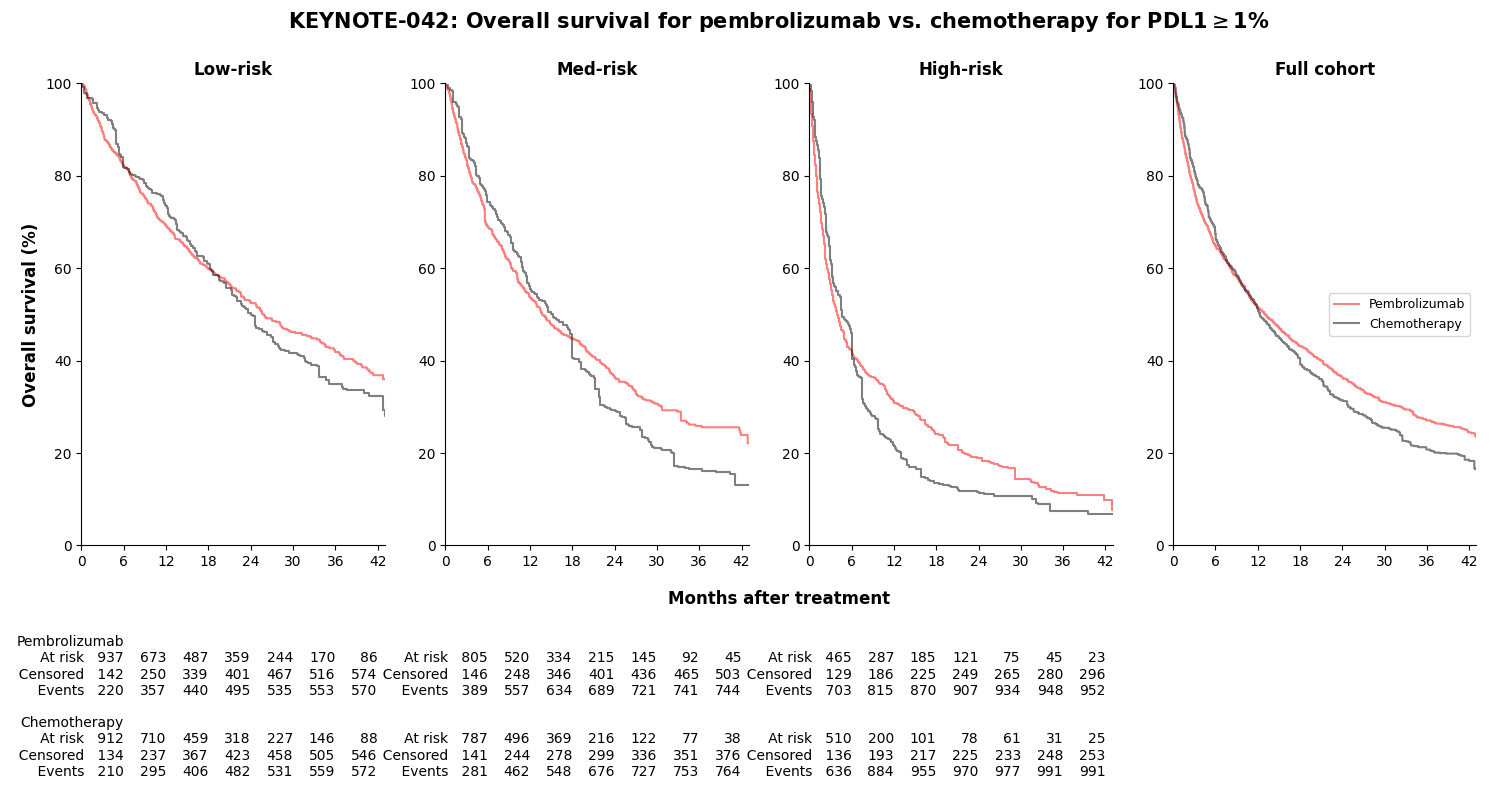

In [114]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

plt.step(kmf_low_pembro_042_iptw.timeline, kmf_low_pembro_042_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_low_plat_042_iptw.timeline, kmf_low_plat_042_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('Overall survival (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_low_pembro_042_iptw, kmf_low_plat_042_iptw, ypos = -0.8, xticks = np.arange(6, 43, 6), labels = ['Pembrolizumab', 'Chemotherapy'])

# Plot survival curves for med risk group. 
plt.subplot(1, 4, 2)

plt.step(kmf_med_pembro_042_iptw.timeline, kmf_med_pembro_042_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_med_plat_042_iptw.timeline, kmf_med_plat_042_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_med_pembro_042_iptw, kmf_med_plat_042_iptw, ypos = -0.8, xticks = np.arange(6, 43, 6), labels = [' ', ' '])

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

plt.step(kmf_high_pembro_042_iptw.timeline, kmf_high_pembro_042_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_high_plat_042_iptw.timeline, kmf_high_plat_042_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_high_pembro_042_iptw, kmf_high_plat_042_iptw, ypos = -0.8, xticks = np.arange(6, 43, 6), labels = [' ', ' '])

# Plot survival curves by treatment for all risk group. 
plt.subplot(1, 4, 4)

plt.step(kmf_all_pembro_042_iptw.timeline, kmf_all_pembro_042_iptw.survival_function_.values*100, color = 'red', alpha = 0.5, label = 'Pembrolizumab')

plt.step(kmf_all_plat_042_iptw.timeline, kmf_all_plat_042_iptw.survival_function_.values*100, color = 'black', alpha = 0.5, label = 'Chemotherapy')

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'center right', prop = {'size': 9})

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title(r'KEYNOTE-042: Overall survival for pembrolizumab vs. chemotherapy for PDL1$\geq$1%', pad = 40, size = 15, weight = 'bold')

plt.show()

### KEYNOTE-024: First-line pembrolizumab vs. platinum-based chemotherapy in those with high PDL1 

**INCLUSION CRITERIA**
* Untreated aNSCLC
* Received first line pemobrolizumab or platinum-based chemotherapy 
* Received appropriate dose of platinum-based chemotherapy
* PDL1 >= 50% and status known within (-inf, +30] days of start of first-line treatment 
* EGFR and ALK negatve

#### Pembrolizumab

In [115]:
df_full = pd.read_csv('df_risk_crude.csv', index_col = 'PatientID', dtype = {'death_status': bool})
df_full.index.nunique()

68483

In [116]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [117]:
key024_pembro = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1')
    .query('IsMaintenanceTherapy == False')
    .query('LineName == "Pembrolizumab"')
    [['PatientID', 'StartDate']]
)

In [118]:
key024_pembro.loc[:, 'pembro'] = 1

In [119]:
row_ID(key024_pembro)

(3648, 3648)

In [120]:
# Dataframe of all therapies received for those receiving first line pembrolizumab only. 
line_therapy_pembro_024 = (
    line_therapy[line_therapy['PatientID'].isin(key024_pembro.PatientID)])

In [121]:
targeted = [
    'Afatinib',
    'Alectinib',
    'Brigatinib',
    'Cabozantinib',
    'Capmatinib',
    'Ceritinib',
    'Crizotinib',
    'Dabrafenib',
    'Dacomitinib',
    'Entrectinib',
    'Erlotinib',
    'Gefitinib',
    'Lorlatinib',
    'Osimertinib',
    'Pralsetinib',
    'Selpercatinib',
    'Sotorasib',
    'Tepotinib',
    'Trametinib',
    'Vandetanib']

In [122]:
# Patients receiving pembrolizumab therapy who later recieve targeted therapy. 
pembro_024_xcross = (
    line_therapy_pembro_024[line_therapy_pembro_024['LineName'].str.contains('|'.join(targeted))].PatientID)

In [123]:
# Select patients who don't receive targeted therapy in future lines.
key024_pembro = key024_pembro[~key024_pembro['PatientID'].isin(pembro_024_xcross)]

In [124]:
row_ID(key024_pembro)

(3582, 3582)

#### Platinum-based chemotherapy 

In [125]:
line_therapy_fl = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1')
    .query('IsMaintenanceTherapy == False')
)

In [126]:
plat_chemo = [
    'Carboplatin',
    'Cisplatin']

immuno = [
    'Atezolizumab',
    'Cemiplimab',
    'Durvalumab',
    'Ipilimumab',
    'Nivolumab',
    'Pembrolizumab'
]

In [127]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('|'.join(plat_chemo)) & 
                ~line_therapy_fl['LineName'].str.contains('|'.join(immuno)) &
                ~line_therapy_fl['LineName'].str.contains('|'.join(targeted)) &
                ~line_therapy_fl['LineName'].str.contains('Clinical Study Drug')].LineName.value_counts().head(10)

Carboplatin,Paclitaxel                  8524
Carboplatin,Pemetrexed                  5417
Bevacizumab,Carboplatin,Pemetrexed      2825
Carboplatin,Paclitaxel Protein-Bound    1826
Bevacizumab,Carboplatin,Paclitaxel      1591
Carboplatin,Gemcitabine                 1224
Cisplatin,Etoposide                      793
Carboplatin,Docetaxel                    780
Cisplatin,Pemetrexed                     684
Carboplatin,Etoposide                    363
Name: LineName, dtype: int64

In [128]:
key024_carb = (
    line_therapy_fl[line_therapy_fl['LineName'].str.contains('Carboplatin') & 
                    ~line_therapy_fl['LineName'].str.contains('|'.join(immuno)) &
                    ~line_therapy_fl['LineName'].str.contains('|'.join(targeted)) &
                    ~line_therapy_fl['LineName'].str.contains('Clinical Study Drug')]
    [['PatientID', 'StartDate']]
)

In [129]:
key024_carb.loc[:, 'carb'] = 1

In [130]:
key024_cis = (
    line_therapy_fl[line_therapy_fl['LineName'].str.contains('Cisplatin') & 
                    ~line_therapy_fl['LineName'].str.contains('|'.join(immuno)) &
                    ~line_therapy_fl['LineName'].str.contains('|'.join(targeted)) &
                    ~line_therapy_fl['LineName'].str.contains('Clinical Study Drug')]
    [['PatientID', 'StartDate']]
)

In [131]:
key024_cis.loc[:, 'carb'] = 0

In [132]:
key024_plat = pd.concat([key024_carb, key024_cis])

In [133]:
key024_plat.loc[:, 'pembro'] = 0

In [134]:
row_ID(key024_plat)

(25861, 25861)

In [135]:
# Dataframe of all therapies received for those receiving first line platinum regimen   
line_therapy_plat_024 = (
    line_therapy[line_therapy['PatientID'].isin(key024_plat.PatientID)])

In [136]:
# Patients receiving platinum therapy who later recieve targeted therapy. 
plat_024_xcross = (
    line_therapy_plat_024[line_therapy_plat_024['LineName'].str.contains('|'.join(targeted))].PatientID)

In [137]:
# Select patients who don't receive targeted therapy in future lines 
key024_plat = key024_plat[~key024_plat['PatientID'].isin(plat_024_xcross)]

In [138]:
row_ID(key024_plat)

(23800, 23800)

#### Platinum-based chemotherapy dosing

#### Carboplatin

In [139]:
med_order = pd.read_csv('MedicationOrder.csv', low_memory = False)

In [140]:
med_order['ExpectedStartDate'] = np.where(med_order['ExpectedStartDate'].isna(), 
                                          med_order['OrderedDate'], 
                                          med_order['ExpectedStartDate'])

In [141]:
med_order.loc[:, 'ExpectedStartDate'] = pd.to_datetime(med_order['ExpectedStartDate'])

In [142]:
key024_plat.loc[:, 'StartDate'] = pd.to_datetime(key024_plat['StartDate'])

In [143]:
med_order_carb = (
    med_order[med_order['PatientID'].isin(key024_plat.query('carb == 1').PatientID)]
    .query('CommonDrugName == "carboplatin"')
)

In [144]:
med_order_carb.shape

(147262, 18)

In [145]:
med_order_carb = pd.merge(med_order_carb, 
                          key024_plat.query('carb == 1')[['PatientID', 'StartDate']], 
                          on = 'PatientID', 
                          how = 'left')

In [146]:
med_order_carb.shape

(147262, 19)

In [147]:
med_order_carb.loc[:, 'date_diff'] = (med_order_carb['ExpectedStartDate'] - med_order_carb['StartDate']).dt.days.abs()

In [148]:
med_order_carb = med_order_carb.query('date_diff <= 14')

In [149]:
carb_index = med_order_carb.groupby('PatientID')['date_diff'].idxmin()

In [150]:
carb_dose = med_order_carb.loc[carb_index].query('RelativeOrderedUnits == "AUC"')[['PatientID', 'RelativeOrderedAmount']]

In [151]:
carb_dose = carb_dose.rename(columns = {'RelativeOrderedAmount': 'carb_dose_auc'})

In [152]:
carb_IDs = carb_dose.query('carb_dose_auc >= 4').PatientID

#### Cisplatin

In [153]:
med_order_cis = (
    med_order[med_order['PatientID'].isin(key024_plat.query('carb == 0').PatientID)]
    .query('CommonDrugName == "cisplatin"')
)

In [154]:
med_order_cis.shape

(10521, 18)

In [155]:
med_order_cis = pd.merge(med_order_cis,
                         key024_plat.query('carb == 0')[['PatientID', 'StartDate']], 
                         on = 'PatientID', 
                         how = 'left')

In [156]:
med_order_cis.shape

(10521, 19)

In [157]:
med_order_cis.loc[:, 'date_diff'] = (med_order_cis['ExpectedStartDate'] - med_order_cis['StartDate']).dt.days.abs()

In [158]:
med_order_cis = med_order_cis.query('date_diff <= 14')

In [159]:
cis_index = med_order_cis.groupby('PatientID')['date_diff'].idxmin()

In [160]:
cis_dose = med_order_cis.loc[cis_index].query('RelativeOrderedUnits == "mg/m2"')[['PatientID', 'RelativeOrderedAmount']]

In [161]:
cis_dose = cis_dose.rename(columns = {'RelativeOrderedAmount': 'cis_dose_mgm2'})

In [162]:
cis_IDs = cis_dose.query('cis_dose_mgm2 >= 75').PatientID

#### Combine chemotherapy and pembrolizumab dataframes 

In [163]:
key024_plat = key024_plat[key024_plat['PatientID'].isin(pd.concat([carb_IDs, cis_IDs]))]

In [164]:
key024_plat = key024_plat.drop(columns = ['carb'])

In [165]:
key_024 = pd.concat([key024_pembro, key024_plat])

In [166]:
row_ID(key_024)

(15943, 15943)

In [167]:
key_024 = pd.merge(key_024, df_full, on = 'PatientID', how = 'inner')

In [168]:
row_ID(key_024)

(15943, 15943)

In [169]:
key_024['StartDate'] = pd.to_datetime(key_024['StartDate'])

#### High PDL1

In [170]:
biomarkers = pd.read_csv('Enhanced_AdvNSCLCBiomarkers.csv')

In [171]:
biomarkers = biomarkers[biomarkers['PatientID'].isin(key_024['PatientID'])]

In [172]:
biomarkers = pd.merge(biomarkers, key_024[['PatientID', 'StartDate']], on = 'PatientID', how = 'left')

In [173]:
row_ID(biomarkers)

(60351, 12520)

In [174]:
biomarkers['StartDate'] = pd.to_datetime(biomarkers['StartDate'])

In [175]:
biomarkers['ResultDate'] = pd.to_datetime(biomarkers['ResultDate'])

In [176]:
biomarkers['SpecimenReceivedDate'] = pd.to_datetime(biomarkers['SpecimenReceivedDate'])

In [177]:
biomarkers.loc[:, 'result_date'] = (
    np.where(biomarkers['ResultDate'].isna(), biomarkers['SpecimenReceivedDate'], biomarkers['ResultDate'])
)

In [178]:
biomarkers.loc[:, 'date_diff'] = (biomarkers['result_date'] - biomarkers['StartDate']).dt.days

In [179]:
lst = ["50% - 59%", "60% - 69%", "70% - 79%", "80% - 89%", "90% - 99%", "100%"]

pdl1_ids = (
    biomarkers
    .query('BiomarkerName == "PDL1"')
    .query('date_diff <=30')
    .query('PercentStaining == @lst')
    .PatientID
    .unique()
)

In [180]:
key_024 = key_024[key_024.PatientID.isin(pdl1_ids)]

In [181]:
row_ID(key_024)

(2887, 2887)

#### Time from treatment to death or censor

In [182]:
mortality_tr = pd.read_csv('mortality_cleaned_tr.csv')

In [183]:
mortality_te = pd.read_csv('mortality_cleaned_te.csv')

In [184]:
mortality_tr = mortality_tr[['PatientID', 'death_date', 'last_activity']]

In [185]:
mortality_te = mortality_te[['PatientID', 'death_date', 'last_activity']]

In [186]:
mortality = pd.concat([mortality_tr, mortality_te], ignore_index = True)
print(len(mortality), mortality.PatientID.is_unique)

68483 True


In [187]:
mortality.loc[:, 'last_activity'] = pd.to_datetime(mortality['last_activity'])

In [188]:
mortality.loc[:, 'death_date'] = pd.to_datetime(mortality['death_date'])

In [189]:
key_024 = pd.merge(key_024, mortality, on = 'PatientID')

In [190]:
row_ID(key_024)

(2887, 2887)

In [191]:
conditions = [
    (key_024['death_status'] == 1),
    (key_024['death_status'] == 0)]

choices = [
    (key_024['death_date'] - key_024['StartDate']).dt.days,
    (key_024['last_activity'] - key_024['StartDate']).dt.days]

key_024.loc[:, 'timerisk_treatment'] = np.select(conditions, choices)

In [192]:
key_024 = key_024.query('timerisk_treatment >= 0')

#### Patient counts

In [193]:
key_024 = (
    key_024
    .query('stage == "IV"')
    .query('EGFR != "positive"')
    .query('ALK != "positive"')
)

In [194]:
low_cutoff_024 = key_024.risk_score.quantile(1/3)

In [195]:
high_cutoff_024 = key_024.risk_score.quantile(2/3)

In [196]:
print('Pembro total:',  key_024.query('pembro == 1').shape[0])
print('High risk:', key_024.query('pembro == 1').query('risk_score >= @high_cutoff_024').shape[0])
print('Med risk:', key_024.query('pembro == 1').query('risk_score < @high_cutoff_024 and risk_score > @low_cutoff_024').shape[0])
print('Low risk:', key_024.query('pembro == 1').query('risk_score <= @low_cutoff_024').shape[0])

Pembro total: 1786
High risk: 593
Med risk: 596
Low risk: 597


In [197]:
print('Platinum total:',  key_024.query('pembro == 0').shape[0])
print('High risk:', key_024.query('pembro == 0').query('risk_score >= @high_cutoff_024').shape[0])
print('Med risk:', key_024.query('pembro == 0').query('risk_score < @high_cutoff_024 and risk_score > @low_cutoff_024').shape[0])
print('Low risk:', key_024.query('pembro == 0').query('risk_score <= @low_cutoff_024').shape[0])

Platinum total: 264
High risk: 91
Med risk: 86
Low risk: 87


#### Survival curves with covariate balancing 

In [198]:
key_024 = key_024.set_index('PatientID')

In [199]:
key_024_iptw = key_024.filter(items = ['death_status',
                                       'timerisk_treatment',
                                       'pembro',
                                       'age',
                                       'gender',
                                       'race',
                                       'PracticeType',
                                       'Histology',
                                       'adv_year',
                                       'commercial',
                                       'medicare',
                                       'medicaid',
                                       'ecog_diagnosis',
                                       'risk_score'])

In [200]:
key_024_iptw['met_cat'] = pd.cut(key_024_iptw['adv_year'],
                                 bins = [2010, 2016, float('inf')],
                                 labels = ['11-16', '17-21'])

In [201]:
conditions = [
    ((key_024_iptw['ecog_diagnosis'] == "1.0") | (key_024_iptw['ecog_diagnosis'] == "0.0")),  
    ((key_024_iptw['ecog_diagnosis'] == "2.0") | (key_024_iptw['ecog_diagnosis'] == "3.0"))
]

choices = ['lt_2', 'gte_2']

key_024_iptw['ecog_2'] = np.select(conditions, choices, default = 'unknown')

In [202]:
key_024_iptw.dtypes

death_status              bool
timerisk_treatment     float64
pembro                   int64
age                      int64
gender                  object
race                    object
PracticeType            object
Histology               object
adv_year                 int64
commercial             float64
medicare               float64
medicaid               float64
ecog_diagnosis          object
risk_score             float64
met_cat               category
ecog_2                  object
dtype: object

In [203]:
to_be_categorical = list(key_024_iptw.select_dtypes(include = ['object']).columns)

In [204]:
to_be_categorical

['gender', 'race', 'PracticeType', 'Histology', 'ecog_diagnosis', 'ecog_2']

In [205]:
to_be_categorical.append('met_cat')

In [206]:
to_be_categorical.remove('ecog_diagnosis')

In [207]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    key_024_iptw[x] = key_024_iptw[x].astype('category')

In [208]:
# List of numeric variables, excluding binary variables. 
numerical_features = ['age']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [209]:
# List of categorical features.
categorical_features = list(key_024_iptw.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [210]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [211]:
key_024_iptw_low = (
    key_024_iptw
    .query('risk_score <= @low_cutoff_024')
    .drop(columns = ['risk_score']))

key_024_iptw_med = (
    key_024_iptw
    .query('risk_score < @high_cutoff_024 and risk_score > @low_cutoff_024')
    .drop(columns = ['risk_score']))

key_024_iptw_high = (
    key_024_iptw
    .query('risk_score >= @high_cutoff_024')
    .drop(columns = ['risk_score']))

key_024_iptw_all = (
    key_024_iptw
    .drop(columns = ['risk_score']))

In [212]:
key_024_low_x = preprocessor.fit_transform(key_024_iptw_low.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'PracticeType',
                                                                            'Histology',
                                                                            'met_cat',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ecog_2']))

key_024_med_x = preprocessor.fit_transform(key_024_iptw_med.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'PracticeType',
                                                                            'Histology',
                                                                            'met_cat',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ecog_2']))

key_024_high_x = preprocessor.fit_transform(key_024_iptw_high.filter(items = ['age',
                                                                              'gender',
                                                                              'race',
                                                                              'PracticeType',
                                                                              'Histology',
                                                                              'met_cat',
                                                                              'commercial',
                                                                              'medicare',
                                                                              'medicaid',
                                                                              'ecog_2']))

key_024_all_x = preprocessor.fit_transform(key_024_iptw_all.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'PracticeType',
                                                                            'Histology',
                                                                            'met_cat',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ecog_2']))

In [213]:
lr_024_low = LogisticRegression(max_iter = 1000)
lr_024_low.fit(key_024_low_x, key_024_iptw_low['pembro'])

LogisticRegression(max_iter=1000)

In [214]:
lr_024_med = LogisticRegression(max_iter = 1000)
lr_024_med.fit(key_024_med_x, key_024_iptw_med['pembro'])

LogisticRegression(max_iter=1000)

In [215]:
lr_024_high = LogisticRegression(max_iter = 1000)
lr_024_high.fit(key_024_high_x, key_024_iptw_high['pembro'])

LogisticRegression(max_iter=1000)

In [216]:
lr_024_all = LogisticRegression(max_iter = 1000)
lr_024_all.fit(key_024_all_x, key_024_iptw_all['pembro'])

LogisticRegression(max_iter=1000)

In [217]:
pred_low = lr_024_low.predict_proba(key_024_low_x)
pred_med = lr_024_med.predict_proba(key_024_med_x)
pred_high = lr_024_high.predict_proba(key_024_high_x)
pred_all = lr_024_all.predict_proba(key_024_all_x)

In [218]:
key_024_iptw_low['ps'] = pred_low[:, 1]
key_024_iptw_med['ps'] = pred_med[:, 1]
key_024_iptw_high['ps'] = pred_high[:, 1]
key_024_iptw_all['ps'] = pred_all[:, 1]

In [219]:
key_024_iptw_low['weight'] = (
    np.where(key_024_iptw_low['pembro'] == 1, 1/key_024_iptw_low['ps'], 1/(1 - key_024_iptw_low['ps'])))

key_024_iptw_med['weight'] = (
    np.where(key_024_iptw_med['pembro'] == 1, 1/key_024_iptw_med['ps'], 1/(1 - key_024_iptw_med['ps'])))

key_024_iptw_high['weight'] = (
    np.where(key_024_iptw_high['pembro'] == 1, 1/key_024_iptw_high['ps'], 1/(1 - key_024_iptw_high['ps'])))

key_024_iptw_all['weight'] = (
    np.where(key_024_iptw_all['pembro'] == 1, 1/key_024_iptw_all['ps'], 1/(1 - key_024_iptw_all['ps'])))

In [220]:
# Low KM curves
kmf_low_pembro_024_iptw = KaplanMeierFitter()
kmf_low_plat_024_iptw = KaplanMeierFitter()

kmf_low_pembro_024_iptw.fit(
    key_024_iptw_low.query('pembro == 1').timerisk_treatment/30,
    key_024_iptw_low.query('pembro == 1').death_status,
    weights = key_024_iptw_low.query('pembro == 1')['weight'])

kmf_low_plat_024_iptw.fit(
    key_024_iptw_low.query('pembro == 0').timerisk_treatment/30,
    key_024_iptw_low.query('pembro == 0').death_status,
    weights = key_024_iptw_low.query('pembro == 0')['weight'])

# Med KM curves
kmf_med_pembro_024_iptw = KaplanMeierFitter()
kmf_med_plat_024_iptw = KaplanMeierFitter()

kmf_med_pembro_024_iptw.fit(
    key_024_iptw_med.query('pembro == 1').timerisk_treatment/30,
    key_024_iptw_med.query('pembro == 1').death_status,
    weights = key_024_iptw_med.query('pembro == 1')['weight'])

kmf_med_plat_024_iptw.fit(
    key_024_iptw_med.query('pembro == 0').timerisk_treatment/30,
    key_024_iptw_med.query('pembro == 0').death_status,
    weights = key_024_iptw_med.query('pembro == 0')['weight'])

# High KM curves 
kmf_high_pembro_024_iptw = KaplanMeierFitter()
kmf_high_plat_024_iptw = KaplanMeierFitter()

kmf_high_pembro_024_iptw.fit(
    key_024_iptw_high.query('pembro == 1').timerisk_treatment/30,
    key_024_iptw_high.query('pembro == 1').death_status,
    weights = key_024_iptw_high.query('pembro == 1')['weight'])

kmf_high_plat_024_iptw.fit(
    key_024_iptw_high.query('pembro == 0').timerisk_treatment/30,
    key_024_iptw_high.query('pembro == 0').death_status,
    weights = key_024_iptw_high.query('pembro == 0')['weight'])

# All KM curves 
kmf_all_pembro_024_iptw = KaplanMeierFitter()
kmf_all_plat_024_iptw = KaplanMeierFitter()

kmf_all_pembro_024_iptw.fit(
    key_024_iptw_all.query('pembro == 1').timerisk_treatment/30,
    key_024_iptw_all.query('pembro == 1').death_status,
    weights = key_024_iptw_all.query('pembro == 1')['weight'])

kmf_all_plat_024_iptw.fit(
    key_024_iptw_all.query('pembro == 0').timerisk_treatment/30,
    key_024_iptw_all.query('pembro == 0').death_status,
    weights = key_024_iptw_all.query('pembro == 0')['weight'])

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:344: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  StatisticalWarning,


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 1843.01 total observations, 597.88 right-censored observations>

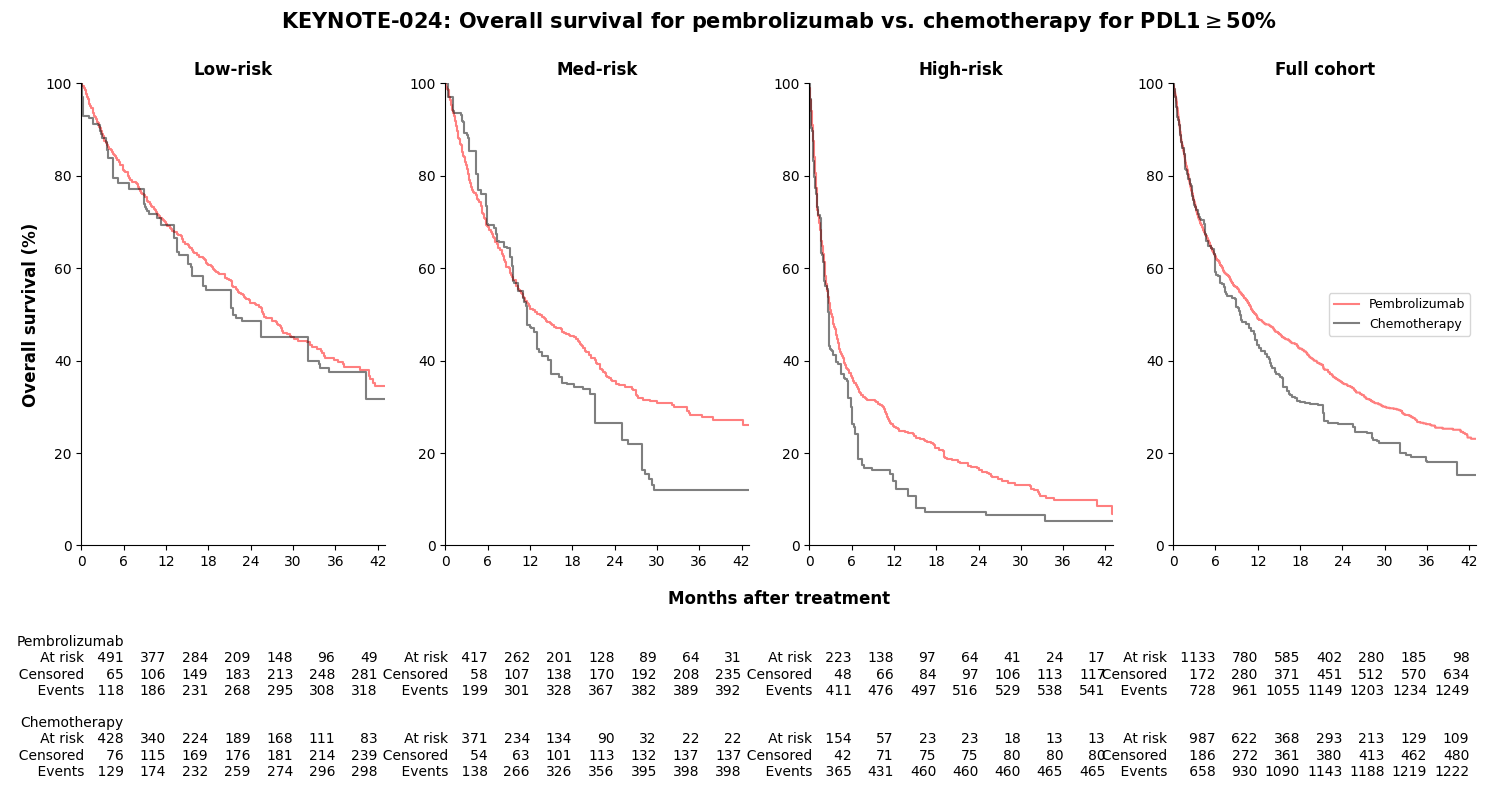

In [221]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

plt.step(kmf_low_pembro_024_iptw.timeline, kmf_low_pembro_024_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_low_plat_024_iptw.timeline, kmf_low_plat_024_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('Overall survival (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_low_pembro_024_iptw, kmf_low_plat_024_iptw, ypos = -0.8, xticks = np.arange(6, 43, 6), labels = ['Pembrolizumab', 'Chemotherapy'])

# Plot survival curves for med risk group. 
plt.subplot(1, 4, 2)

plt.step(kmf_med_pembro_024_iptw.timeline, kmf_med_pembro_024_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_med_plat_024_iptw.timeline, kmf_med_plat_024_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_med_pembro_024_iptw, kmf_med_plat_024_iptw, ypos = -0.8, xticks = np.arange(6, 43, 6), labels = [' ', ' '])

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

plt.step(kmf_high_pembro_024_iptw.timeline, kmf_high_pembro_024_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_high_plat_024_iptw.timeline, kmf_high_plat_024_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_high_pembro_024_iptw, kmf_high_plat_024_iptw, ypos = -0.8, xticks = np.arange(6, 43, 6), labels = [' ', ' '])

# Plot survival curves by treatment for all risk group. 
plt.subplot(1, 4, 4)

plt.step(kmf_all_pembro_024_iptw.timeline, kmf_all_pembro_024_iptw.survival_function_.values*100, color = 'red', alpha = 0.5, label = 'Pembrolizumab')

plt.step(kmf_all_plat_024_iptw.timeline, kmf_all_plat_024_iptw.survival_function_.values*100, color = 'black', alpha = 0.5, label = 'Chemotherapy')

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'center right', prop = {'size': 9})

add_at_risk_counts(kmf_all_pembro_024_iptw, kmf_all_plat_024_iptw, ypos = -0.8, xticks = np.arange(6, 43, 6), labels = [' ', ' '])

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title(r'KEYNOTE-024: Overall survival for pembrolizumab vs. chemotherapy for PDL1$\geq$50%', pad = 40, size = 15, weight = 'bold')

plt.show()

### KEYNOTE-189: First-line pembrolizumab plus chemotherapy vs. chemotherapy

**INCLUSION CRITERIA**
* Untreated stage IV NSCLC
* Received first line pemobrolizumab plus platinum-based chemotherapy or platinum-based chemotherapy
* Received appropriate dose of platinum-based chemotherapy
* EGFR and ALK negative

#### Pembrolizumab + chemotherapy 

In [222]:
df_full = pd.read_csv('df_risk_crude.csv', index_col = 'PatientID', dtype = {'death_status': bool})
df_full.index.nunique()

68483

In [223]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [224]:
line_therapy[line_therapy['LineName'].str.contains('Pemetrexed')].LineName.value_counts().head(10)

Carboplatin,Pemetrexed                              6700
Carboplatin,Pembrolizumab,Pemetrexed                5113
Pemetrexed                                          4711
Bevacizumab,Carboplatin,Pemetrexed                  3459
Bevacizumab,Pemetrexed                              1569
Pembrolizumab,Pemetrexed                            1554
Cisplatin,Pemetrexed                                 811
Bevacizumab,Cisplatin,Pemetrexed                     174
Abiraterone,Carboplatin,Pembrolizumab,Pemetrexed     100
Bevacizumab-Awwb,Carboplatin,Pemetrexed               82
Name: LineName, dtype: int64

In [225]:
line_therapy_fl = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1')
    .query('IsMaintenanceTherapy == False')
)

In [226]:
plat_chemo = [
    'Carboplatin',
    'Cisplatin']

immuno_wout_pembro = [
    'Atezolizumab',
    'Cemiplimab',
    'Durvalumab',
    'Ipilimumab',
    'Nivolumab']

targeted = [
    'Afatinib',
    'Alectinib',
    'Brigatinib',
    'Cabozantinib',
    'Capmatinib',
    'Ceritinib',
    'Crizotinib',
    'Dabrafenib',
    'Dacomitinib',
    'Entrectinib',
    'Erlotinib',
    'Gefitinib',
    'Lorlatinib',
    'Osimertinib',
    'Pralsetinib',
    'Selpercatinib',
    'Sotorasib',
    'Tepotinib',
    'Trametinib',
    'Vandetanib']

In [227]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('|'.join(plat_chemo)) & 
                line_therapy_fl['LineName'].str.contains('Pembrolizumab') &
                ~line_therapy_fl['LineName'].str.contains('|'.join(targeted)) &
                ~line_therapy_fl['LineName'].str.contains('|'.join(immuno_wout_pembro)) &
                ~line_therapy_fl['LineName'].str.contains('Clinical Study Drug')].LineName.value_counts().head(10)

Carboplatin,Pembrolizumab,Pemetrexed                     4275
Carboplatin,Paclitaxel,Pembrolizumab                      803
Carboplatin,Paclitaxel Protein-Bound,Pembrolizumab        534
Abiraterone,Carboplatin,Pembrolizumab,Pemetrexed           79
Carboplatin,Cyclophosphamide,Pembrolizumab,Pemetrexed      31
Cisplatin,Pembrolizumab,Pemetrexed                         27
Carboplatin,Pembrolizumab                                  19
Carboplatin,Docetaxel,Pembrolizumab                        18
Carboplatin,Paclitaxel,Pembrolizumab,Pemetrexed            18
Bevacizumab,Carboplatin,Pembrolizumab,Pemetrexed           10
Name: LineName, dtype: int64

In [228]:
key189_carb_pembro = (
    line_therapy_fl[line_therapy_fl['LineName'].str.contains('Carboplatin') & 
                    line_therapy_fl['LineName'].str.contains('Pembrolizumab') &
                    ~line_therapy_fl['LineName'].str.contains('|'.join(targeted)) &
                    ~line_therapy_fl['LineName'].str.contains('|'.join(immuno_wout_pembro)) &
                    ~line_therapy_fl['LineName'].str.contains('Clinical Study Drug')]
    [['PatientID', 'StartDate']]
)

In [229]:
key189_carb_pembro.loc[:, 'carb'] = 1

In [230]:
key189_cis_pembro = (
    line_therapy_fl[line_therapy_fl['LineName'].str.contains('Cisplatin') & 
                    line_therapy_fl['LineName'].str.contains('Pembrolizumab') &
                    ~line_therapy_fl['LineName'].str.contains('|'.join(targeted)) &
                    ~line_therapy_fl['LineName'].str.contains('|'.join(immuno_wout_pembro)) &
                    ~line_therapy_fl['LineName'].str.contains('Clinical Study Drug')]
    [['PatientID', 'StartDate']]
)

In [231]:
key189_cis_pembro.loc[:, 'carb'] = 0

In [232]:
key189_pembro = pd.concat([key189_carb_pembro, key189_cis_pembro])

In [233]:
key189_pembro.loc[:, 'pembro'] = 1

In [234]:
row_ID(key189_pembro)

(5878, 5878)

In [235]:
# Dataframe of all therapies received for those receiving first line pembrolizumab only. 
line_therapy_pembro_189 = (
    line_therapy[line_therapy['PatientID'].isin(key189_pembro.PatientID)])

In [236]:
# Patients receiving pembrolizumab therapy who later recieve targeted therapy. 
pembro_189_xcross = (
    line_therapy_pembro_189[line_therapy_pembro_189['LineName'].str.contains('|'.join(targeted))].PatientID)

In [237]:
# Select patients who don't receive targeted therapy in future lines.
key189_pembro = key189_pembro[~key189_pembro['PatientID'].isin(pembro_189_xcross)]

In [238]:
row_ID(key189_pembro)

(5673, 5673)

#### Platinum-based chemotherapy

In [239]:
plat_chemo = [
    'Carboplatin',
    'Cisplatin']

immuno = [
    'Atezolizumab',
    'Cemiplimab',
    'Durvalumab',
    'Ipilimumab',
    'Nivolumab',
    'Pembrolizumab'
]

In [240]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('|'.join(plat_chemo)) & 
                ~line_therapy_fl['LineName'].str.contains('|'.join(immuno)) &
                ~line_therapy_fl['LineName'].str.contains('|'.join(targeted)) &
                ~line_therapy_fl['LineName'].str.contains('Clinical Study Drug')].LineName.value_counts().head(10)

Carboplatin,Paclitaxel                  8524
Carboplatin,Pemetrexed                  5417
Bevacizumab,Carboplatin,Pemetrexed      2825
Carboplatin,Paclitaxel Protein-Bound    1826
Bevacizumab,Carboplatin,Paclitaxel      1591
Carboplatin,Gemcitabine                 1224
Cisplatin,Etoposide                      793
Carboplatin,Docetaxel                    780
Cisplatin,Pemetrexed                     684
Carboplatin,Etoposide                    363
Name: LineName, dtype: int64

In [241]:
key189_carb = (
    line_therapy_fl[line_therapy_fl['LineName'].str.contains('Carboplatin') & 
                    ~line_therapy_fl['LineName'].str.contains('|'.join(immuno)) &
                    ~line_therapy_fl['LineName'].str.contains('|'.join(targeted)) &
                    ~line_therapy_fl['LineName'].str.contains('Clinical Study Drug')]
    [['PatientID', 'StartDate']]
)

In [242]:
key189_carb.loc[:, 'carb'] = 1

In [243]:
key189_cis = (
    line_therapy_fl[line_therapy_fl['LineName'].str.contains('Cisplatin') & 
                    ~line_therapy_fl['LineName'].str.contains('|'.join(immuno)) &
                    ~line_therapy_fl['LineName'].str.contains('|'.join(targeted)) &
                    ~line_therapy_fl['LineName'].str.contains('Clinical Study Drug')]
    [['PatientID', 'StartDate']]
)

In [244]:
key189_cis.loc[:, 'carb'] = 0

In [245]:
key189_plat = pd.concat([key189_carb, key189_cis])

In [246]:
key189_plat.loc[:, 'pembro'] = 0

In [247]:
row_ID(key189_plat)

(25861, 25861)

In [248]:
# Dataframe of all therapies received for those receiving first line platinum regimen 
line_therapy_plat_189 = (
    line_therapy[line_therapy['PatientID'].isin(key189_plat.PatientID)])

In [249]:
# Patients receiving platinum therapy who later recieve targeted therapy
plat_189_xcross = (
    line_therapy_plat_189[line_therapy_plat_189['LineName'].str.contains('|'.join(targeted))].PatientID)

In [250]:
# Select patients who don't receive targeted therapy
key189_plat = key189_plat[~key189_plat['PatientID'].isin(plat_189_xcross)]

In [251]:
row_ID(key189_plat)

(23800, 23800)

In [252]:
key_189 = pd.concat([key189_pembro, key189_plat])

In [253]:
row_ID(key_189)

(29473, 29473)

#### Platinum-based chemotherapy dosing

#### Carboplatin

In [254]:
med_order = pd.read_csv('MedicationOrder.csv', low_memory = False)

In [255]:
med_order['ExpectedStartDate'] = np.where(med_order['ExpectedStartDate'].isna(), 
                                          med_order['OrderedDate'], 
                                          med_order['ExpectedStartDate'])

In [256]:
med_order.loc[:, 'ExpectedStartDate'] = pd.to_datetime(med_order['ExpectedStartDate'])

In [257]:
key_189.loc[:, 'StartDate'] = pd.to_datetime(key_189['StartDate'])

In [258]:
med_order_carb = (
    med_order[med_order['PatientID'].isin(key_189.query('carb == 1').PatientID)]
    .query('CommonDrugName == "carboplatin"')
)

In [259]:
med_order_carb.shape

(176309, 18)

In [260]:
med_order_carb = pd.merge(med_order_carb, 
                          key_189.query('carb == 1')[['PatientID', 'StartDate']], 
                          on = 'PatientID', 
                          how = 'left')

In [261]:
med_order_carb.shape

(176309, 19)

In [262]:
med_order_carb.loc[:, 'date_diff'] = (med_order_carb['ExpectedStartDate'] - med_order_carb['StartDate']).dt.days.abs()

In [263]:
med_order_carb = med_order_carb.query('date_diff <= 14')

In [264]:
carb_index = med_order_carb.groupby('PatientID')['date_diff'].idxmin()

In [265]:
carb_dose = med_order_carb.loc[carb_index].query('RelativeOrderedUnits == "AUC"')[['PatientID', 'RelativeOrderedAmount']]

In [266]:
carb_dose = carb_dose.rename(columns = {'RelativeOrderedAmount': 'carb_dose_auc'})

In [267]:
carb_IDs = carb_dose.query('carb_dose_auc >= 4').PatientID

#### Cisplatin

In [268]:
med_order_cis = (
    med_order[med_order['PatientID'].isin(key_189.query('carb == 0').PatientID)]
    .query('CommonDrugName == "cisplatin"')
)

In [269]:
med_order_cis.shape

(10685, 18)

In [270]:
med_order_cis = pd.merge(med_order_cis,
                         key_189.query('carb == 0')[['PatientID', 'StartDate']], 
                         on = 'PatientID', 
                         how = 'left')

In [271]:
med_order_cis.shape

(10685, 19)

In [272]:
med_order_cis.loc[:, 'date_diff'] = (med_order_cis['ExpectedStartDate'] - med_order_cis['StartDate']).dt.days.abs()

In [273]:
med_order_cis = med_order_cis.query('date_diff <= 14')

In [274]:
cis_index = med_order_cis.groupby('PatientID')['date_diff'].idxmin()

In [275]:
cis_dose = med_order_cis.loc[cis_index].query('RelativeOrderedUnits == "mg/m2"')[['PatientID', 'RelativeOrderedAmount']]

In [276]:
cis_dose = cis_dose.rename(columns = {'RelativeOrderedAmount': 'cis_dose_mgm2'})

In [277]:
cis_IDs = cis_dose.query('cis_dose_mgm2 >= 75').PatientID

In [278]:
key_189 = key_189[key_189['PatientID'].isin(pd.concat([carb_IDs, cis_IDs]))]

In [279]:
key_189 = key_189.drop(columns = ['carb'])

In [280]:
row_ID(key_189)

(16634, 16634)

In [281]:
key_189 = pd.merge(key_189, df_full, on = 'PatientID', how = 'inner')

In [282]:
row_ID(key_189)

(16634, 16634)

#### Time from treatment to death or censor

In [283]:
mortality_tr = pd.read_csv('mortality_cleaned_tr.csv')

In [284]:
mortality_te = pd.read_csv('mortality_cleaned_te.csv')

In [285]:
mortality_tr = mortality_tr[['PatientID', 'death_date', 'last_activity']]

In [286]:
mortality_te = mortality_te[['PatientID', 'death_date', 'last_activity']]

In [287]:
mortality = pd.concat([mortality_tr, mortality_te], ignore_index = True)
print(len(mortality), mortality.PatientID.is_unique)

68483 True


In [288]:
mortality.loc[:, 'last_activity'] = pd.to_datetime(mortality['last_activity'])

In [289]:
mortality.loc[:, 'death_date'] = pd.to_datetime(mortality['death_date'])

In [290]:
key_189 = pd.merge(key_189, mortality, on = 'PatientID')

In [291]:
len(key_189)

16634

In [292]:
conditions = [
    (key_189['death_status'] == 1),
    (key_189['death_status'] == 0)]

choices = [
    (key_189['death_date'] - key_189['StartDate']).dt.days,
    (key_189['last_activity'] - key_189['StartDate']).dt.days]

key_189.loc[:, 'timerisk_treatment'] = np.select(conditions, choices)

In [293]:
key_189 = key_189.query('timerisk_treatment >= 0')

#### Patient count

In [294]:
key_189 = (
    key_189
    .query('EGFR != "positive"')
    .query('ALK != "positive"')
)

In [295]:
low_cutoff_189 = key_189.risk_score.quantile(1/3)

In [296]:
high_cutoff_189 = key_189.risk_score.quantile(2/3)

In [297]:
print('Pembro + chemo total:',  key_189.query('pembro == 1').shape[0])
print('High risk:', key_189.query('pembro == 1').query('risk_score >= @high_cutoff_189').shape[0])
print('Med risk:', key_189.query('pembro == 1').query('risk_score < @high_cutoff_189 and risk_score > @low_cutoff_189').shape[0])
print('Low risk:', key_189.query('pembro == 1').query('risk_score <= @low_cutoff_189').shape[0])

Pembro + chemo total: 4178
High risk: 1398
Med risk: 1316
Low risk: 1464


In [298]:
print('Platinum total:',  key_189.query('pembro == 0').shape[0])
print('High risk:', key_189.query('pembro == 0').query('risk_score >= @high_cutoff_189').shape[0])
print('Med risk:', key_189.query('pembro == 0').query('risk_score < @high_cutoff_189 and risk_score > @low_cutoff_189').shape[0])
print('Low risk:', key_189.query('pembro == 0').query('risk_score <= @low_cutoff_189').shape[0])

Platinum total: 12195
High risk: 4060
Med risk: 4141
Low risk: 3994


#### Survival curves with covariate balancing

In [299]:
key_189 = key_189.set_index('PatientID')

In [300]:
key_189_iptw = key_189.filter(items = ['death_status',
                                       'timerisk_treatment',
                                       'pembro',
                                       'age',
                                       'gender',
                                       'race',
                                       'PracticeType',
                                       'Histology',
                                       'adv_year',
                                       'delta_adv_diagnosis',
                                       'commercial',
                                       'medicare',
                                       'medicaid',
                                       'ecog_diagnosis',
                                       'pdl1',
                                       'risk_score'])

In [301]:
key_189_iptw['met_cat'] = pd.cut(key_189_iptw['adv_year'],
                                 bins = [2010, 2018, float('inf')],
                                 labels = ['11-18', '19-22'])

In [302]:
conditions = [
    ((key_189_iptw['pdl1'] == "1-49%") | (key_189_iptw['pdl1'] == "50-100%"))]

choices = ['>0%']

key_189_iptw['pdl1_cat'] = np.select(conditions, choices, default = key_189_iptw['pdl1'])

In [303]:
conditions = [
    ((key_189_iptw['ecog_diagnosis'] == "1.0") | (key_189_iptw['ecog_diagnosis'] == "0.0")),  
    ((key_189_iptw['ecog_diagnosis'] == "2.0") | (key_189_iptw['ecog_diagnosis'] == "3.0"))
]

choices = ['lt_2', 'gte_2']

key_189_iptw['ecog_2'] = np.select(conditions, choices, default = 'unknown')

In [304]:
key_189_iptw.dtypes

death_status               bool
timerisk_treatment      float64
pembro                    int64
age                       int64
gender                   object
race                     object
PracticeType             object
Histology                object
adv_year                  int64
delta_adv_diagnosis       int64
commercial              float64
medicare                float64
medicaid                float64
ecog_diagnosis           object
pdl1                     object
risk_score              float64
met_cat                category
pdl1_cat                 object
ecog_2                   object
dtype: object

In [305]:
to_be_categorical = list(key_189_iptw.select_dtypes(include = ['object']).columns)

In [306]:
to_be_categorical

['gender',
 'race',
 'PracticeType',
 'Histology',
 'ecog_diagnosis',
 'pdl1',
 'pdl1_cat',
 'ecog_2']

In [307]:
to_be_categorical.append('met_cat')

In [308]:
to_be_categorical.remove('pdl1')

In [309]:
to_be_categorical.remove('ecog_diagnosis')

In [310]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    key_189_iptw[x] = key_189_iptw[x].astype('category')

In [311]:
# List of numeric variables, excluding binary variables. 
numerical_features = ['age', 'delta_adv_diagnosis']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [312]:
# List of categorical features.
categorical_features = list(key_189_iptw.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [313]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [314]:
key_189_iptw_low = (
    key_189_iptw
    .query('risk_score <= @low_cutoff_189')
    .drop(columns = ['risk_score']))

key_189_iptw_med = (
    key_189_iptw
    .query('risk_score < @high_cutoff_189 and risk_score > @low_cutoff_189')
    .drop(columns = ['risk_score']))

key_189_iptw_high = (
    key_189_iptw
    .query('risk_score >= @high_cutoff_189')
    .drop(columns = ['risk_score']))

key_189_iptw_all = (
    key_189_iptw
    .drop(columns = ['risk_score']))

In [315]:
key_189_low_x = preprocessor.fit_transform(key_189_iptw_low.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'PracticeType',
                                                                            'Histology',
                                                                            'met_cat',
                                                                            'delta_adv_diagnosis',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ecog_2',
                                                                            'pdl1_cat']))

key_189_med_x = preprocessor.fit_transform(key_189_iptw_med.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'PracticeType',
                                                                            'Histology',
                                                                            'met_cat',
                                                                            'delta_adv_diagnosis',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ecog_2',
                                                                            'pdl1_cat']))

key_189_high_x = preprocessor.fit_transform(key_189_iptw_high.filter(items = ['age',
                                                                              'gender',
                                                                              'race',
                                                                              'PracticeType',
                                                                              'Histology',
                                                                              'met_cat',
                                                                              'delta_adv_diagnosis',
                                                                              'commercial',
                                                                              'medicare',
                                                                              'medicaid',
                                                                              'ecog_2',
                                                                              'pdl1_cat']))

key_189_all_x = preprocessor.fit_transform(key_189_iptw_all.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'PracticeType',
                                                                            'Histology',
                                                                            'met_cat',
                                                                            'delta_adv_diagnosis',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ecog_2',
                                                                            'pdl1_cat']))

In [316]:
lr_189_low = LogisticRegression(max_iter = 1000)
lr_189_low.fit(key_189_low_x, key_189_iptw_low['pembro'])

LogisticRegression(max_iter=1000)

In [317]:
lr_189_med = LogisticRegression(max_iter = 1000)
lr_189_med.fit(key_189_med_x, key_189_iptw_med['pembro'])

LogisticRegression(max_iter=1000)

In [318]:
lr_189_high = LogisticRegression(max_iter = 1000)
lr_189_high.fit(key_189_high_x, key_189_iptw_high['pembro'])

LogisticRegression(max_iter=1000)

In [319]:
lr_189_all = LogisticRegression(max_iter = 1000)
lr_189_all.fit(key_189_all_x, key_189_iptw_all['pembro'])

LogisticRegression(max_iter=1000)

In [320]:
pred_low = lr_189_low.predict_proba(key_189_low_x)
pred_med = lr_189_med.predict_proba(key_189_med_x)
pred_high = lr_189_high.predict_proba(key_189_high_x)
pred_all = lr_189_all.predict_proba(key_189_all_x)

In [321]:
key_189_iptw_low['ps'] = pred_low[:, 1]
key_189_iptw_med['ps'] = pred_med[:, 1]
key_189_iptw_high['ps'] = pred_high[:, 1]
key_189_iptw_all['ps'] = pred_all[:, 1]

In [322]:
key_189_iptw_low['weight'] = (
    np.where(key_189_iptw_low['pembro'] == 1, 1/key_189_iptw_low['ps'], 1/(1 - key_189_iptw_low['ps'])))

key_189_iptw_med['weight'] = (
    np.where(key_189_iptw_med['pembro'] == 1, 1/key_189_iptw_med['ps'], 1/(1 - key_189_iptw_med['ps'])))

key_189_iptw_high['weight'] = (
    np.where(key_189_iptw_high['pembro'] == 1, 1/key_189_iptw_high['ps'], 1/(1 - key_189_iptw_high['ps'])))

key_189_iptw_all['weight'] = (
    np.where(key_189_iptw_all['pembro'] == 1, 1/key_189_iptw_all['ps'], 1/(1 - key_189_iptw_all['ps'])))

In [323]:
# Low KM curves
kmf_low_pembro_189_iptw = KaplanMeierFitter()
kmf_low_plat_189_iptw = KaplanMeierFitter()

kmf_low_pembro_189_iptw.fit(
    key_189_iptw_low.query('pembro == 1').timerisk_treatment/30,
    key_189_iptw_low.query('pembro == 1').death_status,
    weights = key_189_iptw_low.query('pembro == 1')['weight'])

kmf_low_plat_189_iptw.fit(
    key_189_iptw_low.query('pembro == 0').timerisk_treatment/30,
    key_189_iptw_low.query('pembro == 0').death_status,
    weights = key_189_iptw_low.query('pembro == 0')['weight'])

# Med KM curves
kmf_med_pembro_189_iptw = KaplanMeierFitter()
kmf_med_plat_189_iptw = KaplanMeierFitter()

kmf_med_pembro_189_iptw.fit(
    key_189_iptw_med.query('pembro == 1').timerisk_treatment/30,
    key_189_iptw_med.query('pembro == 1').death_status,
    weights = key_189_iptw_med.query('pembro == 1')['weight'])

kmf_med_plat_189_iptw.fit(
    key_189_iptw_med.query('pembro == 0').timerisk_treatment/30,
    key_189_iptw_med.query('pembro == 0').death_status,
    weights = key_189_iptw_med.query('pembro == 0')['weight'])

# High KM curves 
kmf_high_pembro_189_iptw = KaplanMeierFitter()
kmf_high_plat_189_iptw = KaplanMeierFitter()

kmf_high_pembro_189_iptw.fit(
    key_189_iptw_high.query('pembro == 1').timerisk_treatment/30,
    key_189_iptw_high.query('pembro == 1').death_status,
    weights = key_189_iptw_high.query('pembro == 1')['weight'])

kmf_high_plat_189_iptw.fit(
    key_189_iptw_high.query('pembro == 0').timerisk_treatment/30,
    key_189_iptw_high.query('pembro == 0').death_status,
    weights = key_189_iptw_high.query('pembro == 0')['weight'])

# All KM curves 
kmf_all_pembro_189_iptw = KaplanMeierFitter()
kmf_all_plat_189_iptw = KaplanMeierFitter()

kmf_all_pembro_189_iptw.fit(
    key_189_iptw_all.query('pembro == 1').timerisk_treatment/30,
    key_189_iptw_all.query('pembro == 1').death_status,
    weights = key_189_iptw_all.query('pembro == 1')['weight'])

kmf_all_plat_189_iptw.fit(
    key_189_iptw_all.query('pembro == 0').timerisk_treatment/30,
    key_189_iptw_all.query('pembro == 0').death_status,
    weights = key_189_iptw_all.query('pembro == 0')['weight'])

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:344: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  StatisticalWarning,


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 17948 total observations, 4930.09 right-censored observations>

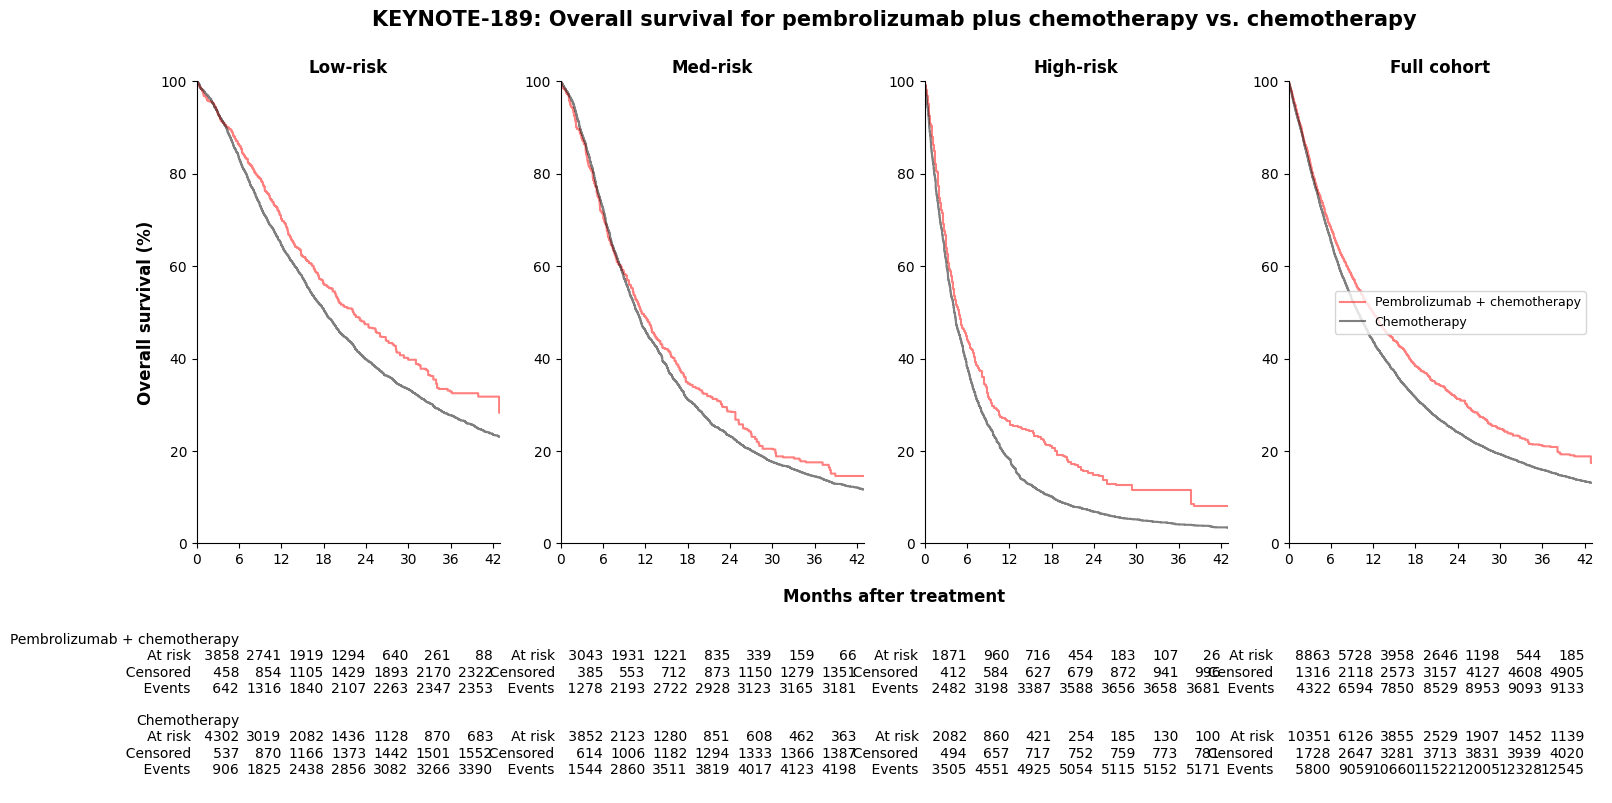

In [324]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

plt.step(kmf_low_pembro_189_iptw.timeline, kmf_low_pembro_189_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_low_plat_189_iptw.timeline, kmf_low_plat_189_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('Overall survival (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_low_pembro_189_iptw, kmf_low_plat_189_iptw, ypos = -0.8, xticks = np.arange(6, 43, 6), labels = ['Pembrolizumab + chemotherapy', 'Chemotherapy'])

# Plot survival curves for med risk group. 
plt.subplot(1, 4, 2)

plt.step(kmf_med_pembro_189_iptw.timeline, kmf_med_pembro_189_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_med_plat_189_iptw.timeline, kmf_med_plat_189_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_med_pembro_189_iptw, kmf_med_plat_189_iptw, ypos = -0.8, xticks = np.arange(6, 43, 6), labels = [' ', ' '])

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

plt.step(kmf_high_pembro_189_iptw.timeline, kmf_high_pembro_189_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_high_plat_189_iptw.timeline, kmf_high_plat_189_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_high_pembro_189_iptw, kmf_high_plat_189_iptw, ypos = -0.8, xticks = np.arange(6, 43, 6), labels = [' ', ' '])

# Plot survival curves by treatment for all risk group. 
plt.subplot(1, 4, 4)

plt.step(kmf_all_pembro_189_iptw.timeline, kmf_all_pembro_189_iptw.survival_function_.values*100, color = 'red', alpha = 0.5, label = 'Pembrolizumab + chemotherapy')

plt.step(kmf_all_plat_189_iptw.timeline, kmf_all_plat_189_iptw.survival_function_.values*100, color = 'black', alpha = 0.5, label = 'Chemotherapy')

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'center right', prop = {'size': 9})

add_at_risk_counts(kmf_all_pembro_189_iptw, kmf_all_plat_189_iptw, ypos = -0.8, xticks = np.arange(6, 43, 6), labels = [' ', ' '])

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title('KEYNOTE-189: Overall survival for pembrolizumab plus chemotherapy vs. chemotherapy', pad = 40, size = 15, weight = 'bold')

plt.show()

### CHECKMATE-078: Second-line nivolumab vs. docetaxel

**INCLUSION CRITERIA**
* Advanced or metastatic NSCLC 
* Progressed on first line platinum-based chemotherapy 
* Received second line nivolumab or docetaxel
* Received appropriate dose of docetaxel
* Prior treatments with docetaxel or immunotherapy contraindicated
* EGFR and ALK negative 

#### Nivolumab 

In [325]:
df_full = pd.read_csv('df_risk_crude.csv', index_col = 'PatientID', dtype = {'death_status': bool})
df_full.index.nunique()

68483

In [326]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [327]:
line_therapy_fl = (
    line_therapy[line_therapy.PatientID.isin(df_full.index)]
    .query('LineNumber == 1')
    .query('IsMaintenanceTherapy == False')
)

In [328]:
targeted = [
    'Afatinib',
    'Alectinib',
    'Brigatinib',
    'Cabozantinib',
    'Capmatinib',
    'Ceritinib',
    'Crizotinib',
    'Dabrafenib',
    'Dacomitinib',
    'Entrectinib',
    'Erlotinib',
    'Gefitinib',
    'Lorlatinib',
    'Osimertinib',
    'Pralsetinib',
    'Selpercatinib',
    'Sotorasib',
    'Tepotinib',
    'Trametinib',
    'Vandetanib']

In [329]:
immunotherapy = [
    'Atezolizumab',
    'Cemiplimab',
    'Durvalumab',
    'Ipilimumab',
    'Nivolumab',
    'Pembrolizumab'
]

In [330]:
fl_plat = (
    line_therapy_fl
    [line_therapy_fl['LineName'].str.contains('Carboplatin|Cisplatin')
     & ~line_therapy_fl['LineName'].str.contains('Docetaxel')
     & ~line_therapy_fl['LineName'].str.contains('|'.join(targeted))
     & ~line_therapy_fl['LineName'].str.contains('|'.join(immunotherapy))]
    .PatientID
)

In [331]:
checkmate_nivo = (
    line_therapy[line_therapy.PatientID.isin(fl_plat)]
    .query('LineNumber == 2')
    .query('LineName == "Nivolumab"')
    [['PatientID', 'StartDate']]
)

In [332]:
checkmate_nivo.loc[:, 'nivo'] = 1

In [333]:
row_ID(checkmate_nivo)

(3397, 3397)

#### Docetaxel

In [334]:
checkmate_dotx = (
    line_therapy[line_therapy.PatientID.isin(fl_plat)]
    .query('LineNumber == 2')
    .query('LineName == "Docetaxel"')
    [['PatientID', 'StartDate']]
)

In [335]:
checkmate_dotx.loc[:, 'nivo'] = 0

In [336]:
row_ID(checkmate_dotx)

(745, 745)

#### Docetaxel dosing

In [337]:
med_order = pd.read_csv('MedicationOrder.csv', low_memory = False)

In [338]:
med_order['ExpectedStartDate'] = np.where(med_order['ExpectedStartDate'].isna(), 
                                          med_order['OrderedDate'], 
                                          med_order['ExpectedStartDate'])

In [339]:
med_order.loc[:, 'ExpectedStartDate'] = pd.to_datetime(med_order['ExpectedStartDate'])

In [340]:
checkmate_dotx.loc[:, 'StartDate'] = pd.to_datetime(checkmate_dotx['StartDate'])

In [341]:
med_order_dotx = (
    med_order[med_order['PatientID'].isin(checkmate_dotx.PatientID)]
    .query('CommonDrugName == "docetaxel"')
)

In [342]:
med_order_dotx.shape

(4537, 18)

In [343]:
med_order_dotx = pd.merge(med_order_dotx, 
                          checkmate_dotx[['PatientID', 'StartDate']], 
                          on = 'PatientID', 
                          how = 'left')

In [344]:
med_order_dotx.shape

(4537, 19)

In [345]:
med_order_dotx.loc[:, 'date_diff'] = (med_order_dotx['ExpectedStartDate'] - med_order_dotx['StartDate']).dt.days.abs()

In [346]:
med_order_dotx = med_order_dotx.query('date_diff <= 14')

In [347]:
dotx_index = med_order_dotx.groupby('PatientID')['date_diff'].idxmin()

In [348]:
dotx_dose = med_order_dotx.loc[dotx_index].query('RelativeOrderedUnits == "mg/m2"')[['PatientID', 'RelativeOrderedAmount']]

In [349]:
dotx_dose = dotx_dose.rename(columns = {'RelativeOrderedAmount': 'dotx_dose_mgm2'})

In [350]:
dotx_IDs = dotx_dose.query('dotx_dose_mgm2 >= 75').PatientID

In [351]:
checkmate_dotx = checkmate_dotx[checkmate_dotx['PatientID'].isin(dotx_IDs)]

#### Combining docetaxel and nivolumab dataframes 

In [352]:
checkmate = pd.concat([checkmate_nivo, checkmate_dotx])

In [353]:
row_ID(checkmate)

(3854, 3854)

In [354]:
checkmate = pd.merge(checkmate, df_full, on = 'PatientID', how = 'inner')

In [355]:
row_ID(checkmate)

(3854, 3854)

In [356]:
checkmate['StartDate'] = pd.to_datetime(checkmate['StartDate'])

#### Time from treatment to death or censor 

In [357]:
mortality_tr = pd.read_csv('mortality_cleaned_tr.csv')

In [358]:
mortality_te = pd.read_csv('mortality_cleaned_te.csv')

In [359]:
mortality_tr = mortality_tr[['PatientID', 'death_date', 'last_activity']]

In [360]:
mortality_te = mortality_te[['PatientID', 'death_date', 'last_activity']]

In [361]:
mortality = pd.concat([mortality_tr, mortality_te], ignore_index = True)
print(len(mortality), mortality.PatientID.is_unique)

68483 True


In [362]:
mortality.loc[:, 'last_activity'] = pd.to_datetime(mortality['last_activity'])

In [363]:
mortality.loc[:, 'death_date'] = pd.to_datetime(mortality['death_date'])

In [364]:
checkmate = pd.merge(checkmate, mortality, on = 'PatientID')

In [365]:
row_ID(checkmate)

(3854, 3854)

In [366]:
conditions = [
    (checkmate['death_status'] == 1),
    (checkmate['death_status'] == 0)]

choices = [
    (checkmate['death_date'] - checkmate['StartDate']).dt.days,
    (checkmate['last_activity'] - checkmate['StartDate']).dt.days]

checkmate.loc[:, 'timerisk_treatment'] = np.select(conditions, choices)

In [367]:
checkmate = checkmate.query('timerisk_treatment >= 0')

#### Patient count 

In [368]:
checkmate = (
    checkmate
    .query('EGFR != "positive"')
    .query('ALK != "positive"')
)

In [369]:
low_cutoff_078 = checkmate.risk_score.quantile(1/3)

In [370]:
high_cutoff_078 = checkmate.risk_score.quantile(2/3)

In [371]:
print('Nivolumab total:',  checkmate.query('nivo == 1').shape[0])
print('High risk:', checkmate.query('nivo == 1').query('risk_score >= @high_cutoff_078').shape[0])
print('Med risk:', checkmate.query('nivo == 1').query('risk_score < @high_cutoff_078 and risk_score > @low_cutoff_078').shape[0])
print('Low risk:', checkmate.query('nivo == 1').query('risk_score <= @low_cutoff_078').shape[0])

Nivolumab total: 3339
High risk: 1118
Med risk: 1108
Low risk: 1113


In [372]:
print('Docetaxel total:',  checkmate.query('nivo == 0').shape[0])
print('High risk:', checkmate.query('nivo == 0').query('risk_score >= @high_cutoff_078').shape[0])
print('Med risk:', checkmate.query('nivo == 0').query('risk_score < @high_cutoff_078 and risk_score > @low_cutoff_078').shape[0])
print('Low risk:', checkmate.query('nivo == 0').query('risk_score <= @low_cutoff_078').shape[0])

Docetaxel total: 450
High risk: 145
Med risk: 155
Low risk: 150


#### Survival curves with covariate balancing

In [373]:
checkmate = checkmate.set_index('PatientID')

In [374]:
check_iptw = checkmate.filter(items = ['death_status',
                                       'timerisk_treatment',
                                       'nivo',
                                       'age',
                                       'gender',
                                       'race',
                                       'PracticeType',
                                       'Histology',
                                       'adv_year',
                                       'delta_adv_diagnosis',
                                       'commercial',
                                       'medicare',
                                       'medicaid',
                                       'ecog_diagnosis',
                                       'pdl1',
                                       'risk_score'])

In [375]:
check_iptw['met_cat'] = pd.cut(check_iptw['adv_year'],
                               bins = [2010, 2015, float('inf')],
                               labels = ['11-15', '16-20'])

In [376]:
conditions = [
    ((check_iptw['pdl1'] == "1-49%") | (check_iptw['pdl1'] == "50-100%"))]

choices = ['>0%']

check_iptw['pdl1_cat'] = np.select(conditions, choices, default = check_iptw['pdl1'])

In [377]:
conditions = [
    ((check_iptw['ecog_diagnosis'] == "1.0") | (check_iptw['ecog_diagnosis'] == "0.0")),  
    ((check_iptw['ecog_diagnosis'] == "2.0") | (check_iptw['ecog_diagnosis'] == "3.0"))
]

choices = ['lt_2', 'gte_2']

check_iptw['ecog_2'] = np.select(conditions, choices, default = 'unknown')

In [378]:
check_iptw.dtypes

death_status               bool
timerisk_treatment      float64
nivo                      int64
age                       int64
gender                   object
race                     object
PracticeType             object
Histology                object
adv_year                  int64
delta_adv_diagnosis       int64
commercial              float64
medicare                float64
medicaid                float64
ecog_diagnosis           object
pdl1                     object
risk_score              float64
met_cat                category
pdl1_cat                 object
ecog_2                   object
dtype: object

In [379]:
to_be_categorical = list(check_iptw.select_dtypes(include = ['object']).columns)

In [380]:
to_be_categorical

['gender',
 'race',
 'PracticeType',
 'Histology',
 'ecog_diagnosis',
 'pdl1',
 'pdl1_cat',
 'ecog_2']

In [381]:
to_be_categorical.append('met_cat')

In [382]:
to_be_categorical.remove('pdl1')

In [383]:
to_be_categorical.remove('ecog_diagnosis')

In [384]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    check_iptw[x] = check_iptw[x].astype('category')

In [385]:
# List of numeric variables, excluding binary variables. 
numerical_features = ['age', 'delta_adv_diagnosis']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [386]:
# List of categorical features.
categorical_features = list(check_iptw.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [387]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [388]:
check_iptw_low = (
    check_iptw
    .query('risk_score <= @low_cutoff_078')
    .drop(columns = ['risk_score']))

check_iptw_med = (
    check_iptw
    .query('risk_score < @high_cutoff_078 and risk_score > @low_cutoff_078')
    .drop(columns = ['risk_score']))

check_iptw_high = (
    check_iptw
    .query('risk_score >= @high_cutoff_078')
    .drop(columns = ['risk_score']))

check_iptw_all = (
    check_iptw
    .drop(columns = ['risk_score']))

In [389]:
check_low_x = preprocessor.fit_transform(check_iptw_low.filter(items = ['age',
                                                                        'gender',
                                                                        'race',
                                                                        'PracticeType',
                                                                        'Histology',
                                                                        'met_cat',
                                                                        'delta_adv_diagnosis',
                                                                        'commercial',
                                                                        'medicare',
                                                                        'medicaid',
                                                                        'ecog_2',
                                                                        'pdl1_cat']))

check_med_x = preprocessor.fit_transform(check_iptw_med.filter(items = ['age',
                                                                        'gender',
                                                                        'race',
                                                                        'PracticeType',
                                                                        'Histology',
                                                                        'met_cat',
                                                                        'delta_adv_diagnosis',
                                                                        'commercial',
                                                                        'medicare',
                                                                        'medicaid',
                                                                        'ecog_2',
                                                                        'pdl1_cat']))

check_high_x = preprocessor.fit_transform(check_iptw_high.filter(items = ['age',
                                                                          'gender',
                                                                          'race',
                                                                          'PracticeType',
                                                                          'Histology',
                                                                          'met_cat',
                                                                          'delta_adv_diagnosis',
                                                                          'commercial',
                                                                          'medicare',
                                                                          'medicaid',
                                                                          'ecog_2',
                                                                          'pdl1_cat']))

check_all_x = preprocessor.fit_transform(check_iptw_all.filter(items = ['age',
                                                                        'gender',
                                                                        'race',
                                                                        'PracticeType',
                                                                        'Histology',
                                                                        'met_cat',
                                                                        'delta_adv_diagnosis',
                                                                        'commercial',
                                                                        'medicare',
                                                                        'medicaid',
                                                                        'ecog_2',
                                                                        'pdl1_cat']))

In [390]:
lr_check_low = LogisticRegression(max_iter = 1000)
lr_check_low.fit(check_low_x, check_iptw_low['nivo'])

LogisticRegression(max_iter=1000)

In [391]:
lr_check_med = LogisticRegression(max_iter = 1000)
lr_check_med.fit(check_med_x, check_iptw_med['nivo'])

LogisticRegression(max_iter=1000)

In [392]:
lr_check_high = LogisticRegression(max_iter = 1000)
lr_check_high.fit(check_high_x, check_iptw_high['nivo'])

LogisticRegression(max_iter=1000)

In [393]:
lr_check_all = LogisticRegression(max_iter = 1000)
lr_check_all.fit(check_all_x, check_iptw_all['nivo'])

LogisticRegression(max_iter=1000)

In [394]:
pred_low = lr_check_low.predict_proba(check_low_x)
pred_med = lr_check_med.predict_proba(check_med_x)
pred_high = lr_check_high.predict_proba(check_high_x)
pred_all = lr_check_all.predict_proba(check_all_x)

In [395]:
check_iptw_low['ps'] = pred_low[:, 1]
check_iptw_med['ps'] = pred_med[:, 1]
check_iptw_high['ps'] = pred_high[:, 1]
check_iptw_all['ps'] = pred_all[:, 1]

In [396]:
check_iptw_low['weight'] = (
    np.where(check_iptw_low['nivo'] == 1, 1/check_iptw_low['ps'], 1/(1 - check_iptw_low['ps'])))

check_iptw_med['weight'] = (
    np.where(check_iptw_med['nivo'] == 1, 1/check_iptw_med['ps'], 1/(1 - check_iptw_med['ps'])))

check_iptw_high['weight'] = (
    np.where(check_iptw_high['nivo'] == 1, 1/check_iptw_high['ps'], 1/(1 - check_iptw_high['ps'])))

check_iptw_all['weight'] = (
    np.where(check_iptw_all['nivo'] == 1, 1/check_iptw_all['ps'], 1/(1 - check_iptw_all['ps'])))

In [397]:
# Low KM curves
kmf_low_nivo_check_iptw = KaplanMeierFitter()
kmf_low_dotx_check_iptw = KaplanMeierFitter()

kmf_low_nivo_check_iptw.fit(
    check_iptw_low.query('nivo == 1').timerisk_treatment/30,
    check_iptw_low.query('nivo == 1').death_status,
    weights = check_iptw_low.query('nivo == 1')['weight'])

kmf_low_dotx_check_iptw.fit(
    check_iptw_low.query('nivo == 0').timerisk_treatment/30,
    check_iptw_low.query('nivo == 0').death_status,
    weights = check_iptw_low.query('nivo == 0')['weight'])

# Med KM curves
kmf_med_nivo_check_iptw = KaplanMeierFitter()
kmf_med_dotx_check_iptw = KaplanMeierFitter()

kmf_med_nivo_check_iptw.fit(
    check_iptw_med.query('nivo == 1').timerisk_treatment/30,
    check_iptw_med.query('nivo == 1').death_status,
    weights = check_iptw_med.query('nivo == 1')['weight'])

kmf_med_dotx_check_iptw.fit(
    check_iptw_med.query('nivo == 0').timerisk_treatment/30,
    check_iptw_med.query('nivo == 0').death_status,
    weights = check_iptw_med.query('nivo == 0')['weight'])

# High KM curves 
kmf_high_nivo_check_iptw = KaplanMeierFitter()
kmf_high_dotx_check_iptw = KaplanMeierFitter()

kmf_high_nivo_check_iptw.fit(
    check_iptw_high.query('nivo == 1').timerisk_treatment/30,
    check_iptw_high.query('nivo == 1').death_status,
    weights = check_iptw_high.query('nivo == 1')['weight'])

kmf_high_dotx_check_iptw.fit(
    check_iptw_high.query('nivo == 0').timerisk_treatment/30,
    check_iptw_high.query('nivo == 0').death_status,
    weights = check_iptw_high.query('nivo == 0')['weight'])

# All KM curves 
kmf_all_nivo_check_iptw = KaplanMeierFitter()
kmf_all_dotx_check_iptw = KaplanMeierFitter()

kmf_all_nivo_check_iptw.fit(
    check_iptw_all.query('nivo == 1').timerisk_treatment/30,
    check_iptw_all.query('nivo == 1').death_status,
    weights = check_iptw_all.query('nivo == 1')['weight'])

kmf_all_dotx_check_iptw.fit(
    check_iptw_all.query('nivo == 0').timerisk_treatment/30,
    check_iptw_all.query('nivo == 0').death_status,
    weights = check_iptw_all.query('nivo == 0')['weight'])

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:344: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  StatisticalWarning,


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 3762.15 total observations, 493.787 right-censored observations>

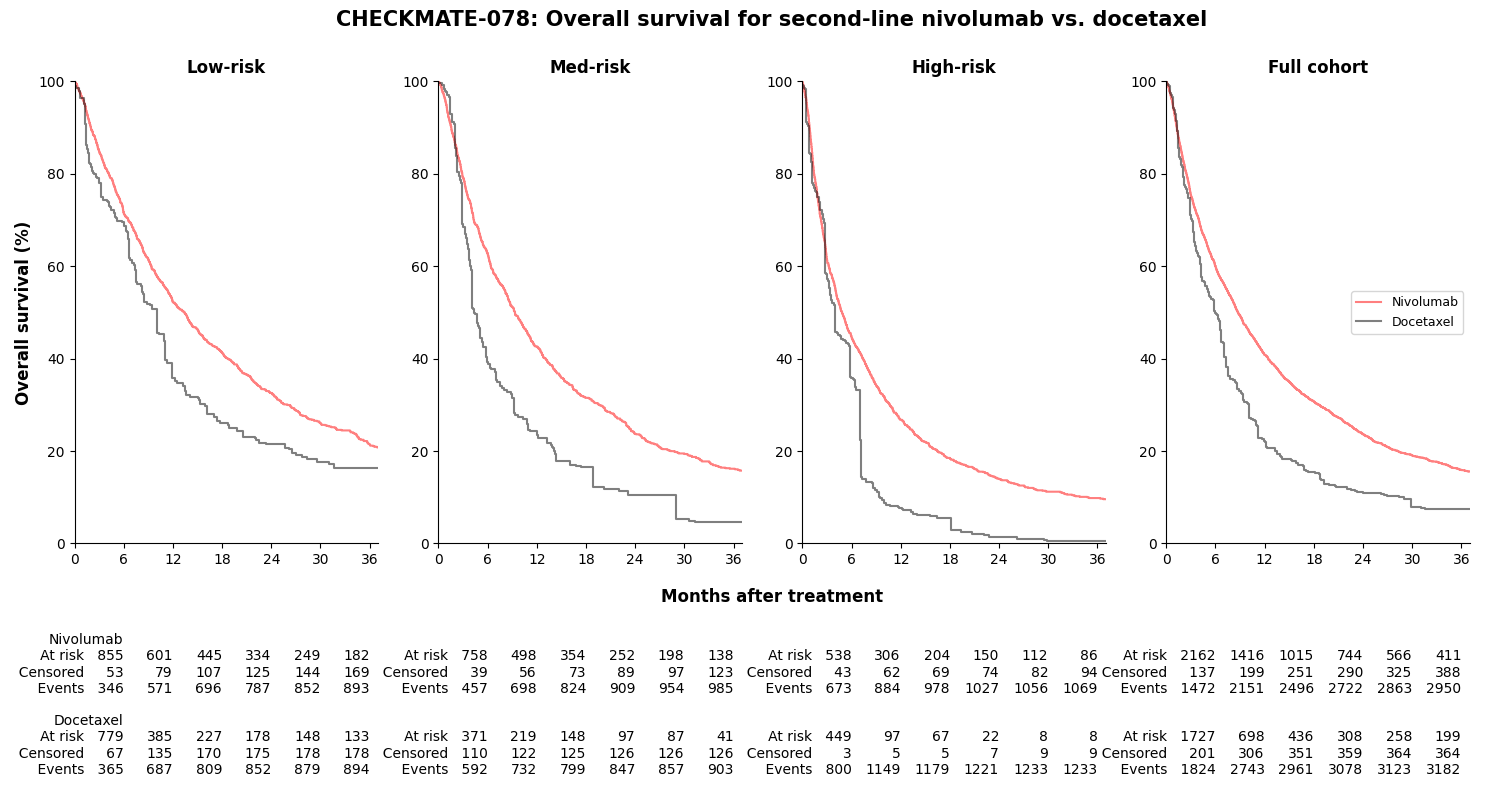

In [398]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

plt.step(kmf_low_nivo_check_iptw.timeline, kmf_low_nivo_check_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_low_dotx_check_iptw.timeline, kmf_low_dotx_check_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 37, 6))
plt.xlim(0, 37)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('Overall survival (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_low_nivo_check_iptw, kmf_low_dotx_check_iptw, ypos = -0.8, xticks = np.arange(6, 37, 6), labels = ['Nivolumab', 'Docetaxel'])

# Plot survival curves for med risk group. 
plt.subplot(1, 4, 2)

plt.step(kmf_med_nivo_check_iptw.timeline, kmf_med_nivo_check_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_med_dotx_check_iptw.timeline, kmf_med_dotx_check_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 37, 6))
plt.xlim(0, 37)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_med_nivo_check_iptw, kmf_med_dotx_check_iptw, ypos = -0.8, xticks = np.arange(6, 37, 6), labels = [' ', ' '])

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

plt.step(kmf_high_nivo_check_iptw.timeline, kmf_high_nivo_check_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_high_dotx_check_iptw.timeline, kmf_high_dotx_check_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 37, 6))
plt.xlim(0, 37)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(kmf_high_nivo_check_iptw, kmf_high_dotx_check_iptw, ypos = -0.8, xticks = np.arange(6, 37, 6), labels = [' ', ' '])

# Plot survival curves by treatment for all risk group. 
plt.subplot(1, 4, 4)

plt.step(kmf_all_nivo_check_iptw.timeline, kmf_all_nivo_check_iptw.survival_function_.values*100, color = 'red', alpha = 0.5, label = 'Nivolumab')

plt.step(kmf_all_dotx_check_iptw.timeline, kmf_all_dotx_check_iptw.survival_function_.values*100, color = 'black', alpha = 0.5, label = 'Docetaxel')

plt.xticks(np.arange(0, 37, 6))
plt.xlim(0, 37)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'center right', prop = {'size': 9})

add_at_risk_counts(kmf_all_nivo_check_iptw, kmf_all_dotx_check_iptw, ypos = -0.8, xticks = np.arange(6, 37, 6), labels = [' ', ' '])

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title('CHECKMATE-078: Overall survival for second-line nivolumab vs. docetaxel', pad = 40, size = 15, weight = 'bold')

plt.show()